In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

!gdown https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90
!gdown https://drive.google.com/uc?id=18BuPskF5yQNZpGMv9nzDuSe20KCmEwvU

# Definir rutas
zip_path = '/content/split_data608.zip'
extract_path = '/content'

# Crear carpeta de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Archivo descomprimido en:", extract_path)

# Definir rutas
zip_path = '/content/DDMP_UNet-20250629T195613Z-1-001.zip'
extract_path = '/content'

# Crear carpeta de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Archivo descomprimido en:", extract_path)

Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90
From (redirected): https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90&confirm=t&uuid=0aa07bd1-f107-4f8f-a38b-6cfe9603f28f
To: /content/split_data608.zip
100% 1.48G/1.48G [00:29<00:00, 49.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=18BuPskF5yQNZpGMv9nzDuSe20KCmEwvU
From (redirected): https://drive.google.com/uc?id=18BuPskF5yQNZpGMv9nzDuSe20KCmEwvU&confirm=t&uuid=abc5eb19-96f7-40f3-b6ec-96c8e50601a5
To: /content/DDMP_UNet-20250629T195613Z-1-001.zip
100% 979M/979M [00:31<00:00, 31.3MB/s]
Archivo descomprimido en: /content
Archivo descomprimido en: /content


In [ ]:
!pip install lightning --quiet
!pip install torchviz --quiet
!pip install hiddenlayer --quiet
!pip install onnx --quiet
!pip install lpips --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image

def check_image_sizes(directory):
    sizes = {}
    print(f"\n📂 Analizando: {directory}")
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        try:
            with Image.open(path) as img:
                size = img.size  # (width, height)
                sizes[size] = sizes.get(size, 0) + 1
        except Exception as e:
            print(f"❌ Error con {filename}: {e}")

    for size, count in sizes.items():
        print(f"🖼️ {count} imágenes de tamaño {size[0]}x{size[1]}")
    if not sizes:
        print("⚠️ No se encontraron imágenes válidas.")

# Carpetas a verificar
check_image_sizes("/content/split_data/train/acs")  # LR
check_image_sizes("/content/split_data/train/dud")  # HR
check_image_sizes("/content/split_data/val/acs")    # LR
check_image_sizes("/content/split_data/val/dud")    # HR


📂 Analizando: /content/split_data/train/acs
🖼️ 103129 imágenes de tamaño 608x608

📂 Analizando: /content/split_data/train/dud
🖼️ 103129 imágenes de tamaño 152x152

📂 Analizando: /content/split_data/val/acs
🖼️ 12891 imágenes de tamaño 608x608

📂 Analizando: /content/split_data/val/dud
🖼️ 12891 imágenes de tamaño 152x152


In [ ]:
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
import os, glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import lightning as L
from lightning.fabric.utilities.seed import seed_everything
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping

import sys
sys.path.append("/content/DDMP_UNet")
from src.callbacks.metrics_new import MetricsCallbackDDPM
from src.ddpm.ddpm_A import DDPM_2D

In [ ]:
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512],
    loss_fn=nn.MSELoss(),
)

# Simulamos entrada y referencia con resolución 152x152
x = torch.randn(1, 1, 152, 152)        # Imagen original
ref = torch.randn(1, 1, 152, 152)      # Imagen de referencia
t = torch.tensor([0])                 # Un paso temporal arbitrario

# Concatenamos en canal: [1, 2, 152, 152]
x_cat = torch.cat([x, ref], dim=1)

# Pasamos por el modelo
out = ddpm_model(x_cat, t)

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
print(ddpm_model)

DDPM_2D(
  (loss): MSELoss()
  (time_embedding): PositionalEncoding()
  (model): UNetSuperRes(
    (loss_fn): MSELoss()
    (downs): ModuleList(
      (0): Down_Res_GroupNorm_SiLU_D(
        (module): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): ResBlockGroupNorm(
            (main_path): Sequential(
              (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): GroupNorm(32, 128, eps=0.001, affine=True)
              (2): SiLU(inplace=True)
              (3): Dropout(p=0.1, inplace=False)
              (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (5): GroupNorm(32, 128, eps=0.001, affine=True)
              (6): SiLU(inplace=True)
              (7): Dropout(p=0.1, inplace=False)
            )
            (residual_connection): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
       

In [ ]:
from torchsummary import summary

# Ejemplo con batch=1, 2 canales, 152x152
summary(ddpm_model, input_size=(2, 152, 152))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 152, 152]             128
            Conv2d-2         [-1, 64, 152, 152]           1,152
         GroupNorm-3         [-1, 64, 152, 152]             128
              SiLU-4         [-1, 64, 152, 152]               0
           Dropout-5         [-1, 64, 152, 152]               0
            Conv2d-6         [-1, 64, 152, 152]          36,864
         GroupNorm-7         [-1, 64, 152, 152]             128
              SiLU-8         [-1, 64, 152, 152]               0
           Dropout-9         [-1, 64, 152, 152]               0
ResBlockGroupNorm-10         [-1, 64, 152, 152]               0
        MaxPool2d-11           [-1, 64, 76, 76]               0
           Conv2d-12          [-1, 128, 76, 76]           8,192
           Conv2d-13          [-1, 128, 76, 76]          73,728
        GroupNorm-14          [-1, 128,

In [ ]:
from torchviz import make_dot

# Prepara una entrada de ejemplo
x = torch.randn(1, 2, 152, 152)  # 2 canales por la concatenación
t = torch.randint(0, 400, (1,), dtype=torch.long)

ddpm_model.eval()
out = ddpm_model(x, t)

# Visualiza el grafo de cómputo
dot = make_dot(out, params=dict(ddpm_model_superres.named_parameters()))
dot.format = "png"
dot.render("ddpm_model_graph_make_dot")  # genera 'ddpm_model_graph.png'
dot.view()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [ ]:
dummy_input = (torch.randn(1, 2, 152, 152), torch.tensor([0]))
torch.onnx.export(ddpm_model, dummy_input, "ddpm_model.onnx",
                  input_names=["x", "t"], output_names=["output"],
                  opset_version=11)


In [ ]:
with torch.no_grad():
    ddpm_model.eval()
    out = ddpm_model(x_cat, t)
    print(f"[AFTER CALL] Output shape: {out.shape}")

[AFTER CALL] Output shape: torch.Size([1, 1, 152, 152])


In [ ]:
with torch.no_grad():
    ddpm_model.eval()
    out = ddpm_model.forward(x_cat, t)


# Super Resolución

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DDPM_SuperRes_Wrapper(nn.Module):
    def __init__(self, ddpm_model, upscale_factor=4):
        super().__init__()
        self.ddpm = ddpm_model
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=upscale_factor, mode='bilinear', align_corners=True),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)  # Conv para afinar después del upsampling
        )

    def forward(self, x, t=None):
        out = self.ddpm(x, t)
        out_up = self.upscale(out)
        return out_up
# Modelo original
ddpm_model = DDPM_2D(
    in_channels=1,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
)

# Envuelto con superresolución
ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model, upscale_factor=4)


[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
x = torch.randn(1, 2, 152, 152)
t = torch.tensor([0])

ddpm_model_superres.eval()
with torch.no_grad():
    y = ddpm_model_superres(x, t)
    print("Output shape:", y.shape)  # Esperado: [1, 1, 608, 608]

Output shape: torch.Size([1, 1, 608, 608])


# Entrenamiento!!

In [ ]:
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
import os, glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import lightning as L
from lightning.fabric.utilities.seed import seed_everything
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping

import sys
sys.path.append("/content/DDMP_UNet")
from src.callbacks.metrics_new import MetricsCallbackDDPM
from src.ddpm.ddpm_A import DDPM_2D

In [ ]:
# Modelo base
ddpm_model = DDPM_2D(
    in_channels=1,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=torch.nn.MSELoss(),
)

# Wrapper con superresolución
ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model, upscale_factor=4)


[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform_lr = transforms.Compose([
            transforms.ToTensor()
        ])
        self.transform_hr = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        return {
            'lr': self.transform_lr(lr_img),
            'hr': self.transform_hr(hr_img)
        }

train_dataset = SRDataset(
    hr_dir='/content/split_data/train/acs/',
    lr_dir='/content/split_data/train/dud/'
)

val_dataset = SRDataset(
    hr_dir='/content/split_data/val/acs/',
    lr_dir='/content/split_data/val/dud/'
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)


In [ ]:
# Callbacks
checkpoint_cb = ModelCheckpoint(
    monitor='val/loss',
    save_top_k=1,
    mode='min',
    filename='ddpm-superres-best'
)

early_stop_cb = EarlyStopping(
    monitor='val/loss',
    patience=10,
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name="ddpm_superres")

# Semilla
seed_everything(42)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [ ]:
# Ruta en Google Drive
drive_output_path = "/content/drive/MyDrive/Entrenamiento superResolucion"

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Logger en carpeta de Drive
logger = TensorBoardLogger(
    save_dir=drive_output_path,
    name="logs"
)

# Guardar el mejor modelo (por val/loss mínimo)
checkpoint_best = ModelCheckpoint(
    dirpath=drive_output_path,
    filename="best-checkpoint",
    monitor="val/loss",
    save_top_k=1,
    mode="min",
    save_weights_only=False,
)

# Guardar modelo en CADA epoch (con nombre por epoch)
checkpoint_all = ModelCheckpoint(
    dirpath=drive_output_path,
    filename="epoch-{epoch:02d}-val_loss-{val/loss:.4f}",
    save_top_k=-1,  # Guardar todos
    every_n_epochs=1,
    save_weights_only=False,
)


In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ruta en Google Drive
save_dir = "/content/drive/MyDrive/Entrenamiento superResolucion"
os.makedirs(save_dir, exist_ok=True)

# Modelo
ddpm_model = DDPM_2D(
    in_channels=1,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512],
    loss_fn=nn.MSELoss(),
).to(device)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=1e-3)

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
from torchviz import make_dot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm_model_superres.to(device)

x = torch.randn(1, 2, 152, 152).to(device)
t = torch.randint(0, 400, (1,), dtype=torch.long).to(device)

ddpm_model_superres.eval()
out = ddpm_model_superres(x, t)

dot = make_dot(out, params=dict(ddpm_model_superres.named_parameters()))
dot.format = "png"
dot.render("ddpm_model_graph_make_dot")
dot.view()


NameError: name 'x_2ch' is not defined

In [ ]:
from torchsummary import summary

# Ejemplo con batch=1, 2 canales, 152x152
summary(ddpm_model_superres, input_size=(2, 152, 152))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 152, 152]             128
            Conv2d-2         [-1, 64, 152, 152]           1,152
         GroupNorm-3         [-1, 64, 152, 152]             128
              SiLU-4         [-1, 64, 152, 152]               0
           Dropout-5         [-1, 64, 152, 152]               0
            Conv2d-6         [-1, 64, 152, 152]          36,864
         GroupNorm-7         [-1, 64, 152, 152]             128
              SiLU-8         [-1, 64, 152, 152]               0
           Dropout-9         [-1, 64, 152, 152]               0
ResBlockGroupNorm-10         [-1, 64, 152, 152]               0
        MaxPool2d-11           [-1, 64, 76, 76]               0
           Conv2d-12          [-1, 128, 76, 76]           8,192
           Conv2d-13          [-1, 128, 76, 76]          73,728
        GroupNorm-14          [-1, 128,

# Entrenamiento

In [ ]:
#No ruido
import os
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn

from torchvision.transforms import functional as TVF  # Para transformaciones de imagen
import torch.nn.functional as F  # Para funciones de pérdida
from torch.utils.data import Dataset  # Añade esto si falta


class DDPM_SuperRes_Wrapper(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )
        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)


class DDPM_SuperRes_Wrapper_ELU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.ELU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)

class DDPM_SuperRes_Wrapper_PReLU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.PReLU(num_parameters=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)
#===================================================================

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)  # Cambiado
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)  # Cambiado
        return {
            'lr': self.transform(lr_gray),
            'hr': self.transform(hr_gray)
        }

train_dataset = SRDataset(
    hr_dir='/content/split_data/train/acs/',
    lr_dir='/content/split_data/train/dud/'
)

val_dataset = SRDataset(
    hr_dir='/content/split_data/val/acs/',
    lr_dir='/content/split_data/val/dud/'
)

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

# =================================================================================

# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion"

# Crear directorio si no existe
os.makedirs(save_dir, exist_ok=True)

# Hiperparámetros
num_epochs = 100
lr = 1e-3

# Modelo y optimizador
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=lr,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
).to(device)

ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model).to(device)
optimizer = torch.optim.Adam(ddpm_model_superres.parameters(), lr=lr)

# Entrenamiento
best_val_loss = float('inf')
history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': []
}

for epoch in range(num_epochs):
    ddpm_model_superres.train()
    train_losses = []

    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for batch in train_pbar:
        x_lr = batch["lr"].to(device)
        x_hr = batch["hr"].to(device)

        optimizer.zero_grad()
        pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t

        # Usamos torch.nn.functional.mse_loss
        loss = F.mse_loss(pred_hr, x_hr)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_pbar.set_postfix({'loss': loss.item()})

    # Validación
    ddpm_model_superres.eval()
    val_losses = []

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        for batch in val_pbar:
            x_lr = batch["lr"].to(device)
            x_hr = batch["hr"].to(device)

            pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t
            val_loss = F.mse_loss(pred_hr, x_hr)
            val_losses.append(val_loss.item())
            val_pbar.set_postfix({'val_loss': val_loss.item()})

    # Calcular métricas
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)

    # Guardar histórico
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    # Guardar estadísticas en CSV
    stats_df = pd.DataFrame(history)
    stats_df.to_csv(os.path.join(save_dir, 'training_stats.csv'), index=False)

    # Guardar modelo cada época
    epoch_model_path = os.path.join(save_dir, f'model_epoch_{epoch+1:03d}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': ddpm_model_superres.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, epoch_model_path)

    # Guardar mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': ddpm_model_superres.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, best_model_path)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

print("¡Entrenamiento completado!")

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


Epoch 1/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.98it/s, val_loss=0.000363]


Epoch 1/100 | Train Loss: 0.0010 | Val Loss: 0.0003


Epoch 2/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 131.20it/s, val_loss=0.000266]


Epoch 2/100 | Train Loss: 0.0002 | Val Loss: 0.0002


Epoch 3/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.64it/s, val_loss=0.000979]


Epoch 3/100 | Train Loss: 0.0004 | Val Loss: 0.0005


Epoch 4/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.62it/s, val_loss=0.00098]


Epoch 4/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 5/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 131.47it/s, val_loss=0.000976]


Epoch 5/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 6/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 117.15it/s, val_loss=0.00098]


Epoch 6/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 7/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.49it/s, val_loss=0.000979]


Epoch 7/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 8/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.78it/s, val_loss=0.000977]


Epoch 8/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 9/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.96it/s, val_loss=0.000981]


Epoch 9/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 10/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.24it/s, val_loss=0.000977]


Epoch 10/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 11/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.30it/s, val_loss=0.000977]


Epoch 11/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 12/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.44it/s, val_loss=0.000982]


Epoch 12/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 13/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.87it/s, val_loss=0.00098]


Epoch 13/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 14/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.60it/s, val_loss=0.000979]


Epoch 14/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 15/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.23it/s, val_loss=0.000976]


Epoch 15/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 16/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.36it/s, val_loss=0.00098]


Epoch 16/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 17/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.32it/s, val_loss=0.00098]


Epoch 17/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 18/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.72it/s, val_loss=0.000981]


Epoch 18/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 19/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.66it/s, val_loss=0.00098]


Epoch 19/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 20/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.80it/s, val_loss=0.000979]


Epoch 20/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 21/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.89it/s, val_loss=0.00098]


Epoch 21/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 22/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 125.05it/s, val_loss=0.000974]


Epoch 22/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 23/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.46it/s, val_loss=0.000981]


Epoch 23/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 24/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.59it/s, val_loss=0.000982]


Epoch 24/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 25/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.29it/s, val_loss=0.000979]


Epoch 25/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 26/100 [Val]: 100%|██████████| 12891/12891 [01:45<00:00, 122.03it/s, val_loss=0.000981]


Epoch 26/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 27/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.68it/s, val_loss=0.000978]


Epoch 27/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 28/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.85it/s, val_loss=0.000981]


Epoch 28/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 29/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.51it/s, val_loss=0.000975]


Epoch 29/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 30/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.33it/s, val_loss=0.000979]


Epoch 30/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 31/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.43it/s, val_loss=0.000978]


Epoch 31/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 32/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.83it/s, val_loss=0.00098]


Epoch 32/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 33/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.78it/s, val_loss=0.000975]


Epoch 33/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 34/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.45it/s, val_loss=0.00098]


Epoch 34/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 35/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.12it/s, val_loss=0.000975]


Epoch 35/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 36/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.95it/s, val_loss=0.000977]


Epoch 36/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 37/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.42it/s, val_loss=0.000983]


Epoch 37/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 38/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.79it/s, val_loss=0.000978]


Epoch 38/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 39/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.40it/s, val_loss=0.000977]


Epoch 39/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 40/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.31it/s, val_loss=0.000982]


Epoch 40/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 41/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.35it/s, val_loss=0.000981]


Epoch 41/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 42/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.67it/s, val_loss=0.000978]


Epoch 42/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 43/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.88it/s, val_loss=0.000979]


Epoch 43/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 44/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.45it/s, val_loss=0.000979]


Epoch 44/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 45/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.94it/s, val_loss=0.00098]


Epoch 45/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 46/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.81it/s, val_loss=0.000979]


Epoch 46/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 47/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 130.03it/s, val_loss=0.000975]


Epoch 47/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 48/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.63it/s, val_loss=0.000982]


Epoch 48/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 49/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.66it/s, val_loss=0.000977]


Epoch 49/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 50/100 [Val]: 100%|██████████| 12891/12891 [01:38<00:00, 130.42it/s, val_loss=0.000983]


Epoch 50/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 51/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 130.02it/s, val_loss=0.000978]


Epoch 51/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 52/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 130.12it/s, val_loss=0.00098]


Epoch 52/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 53/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 127.64it/s, val_loss=0.000977]


Epoch 53/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 54/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.68it/s, val_loss=0.000975]


Epoch 54/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 55/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.67it/s, val_loss=0.000982]


Epoch 55/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 56/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.75it/s, val_loss=0.000978]


Epoch 56/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 57/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.72it/s, val_loss=0.000974]


Epoch 57/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 58/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.18it/s, val_loss=0.000978]


Epoch 58/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 59/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.16it/s, val_loss=0.000982]


Epoch 59/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 60/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.95it/s, val_loss=0.000976]


Epoch 60/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 61/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 125.11it/s, val_loss=0.000981]


Epoch 61/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 62/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.95it/s, val_loss=0.00098]


Epoch 62/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 63/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.23it/s, val_loss=0.000978]


Epoch 63/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 64/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.16it/s, val_loss=0.000982]


Epoch 64/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 65/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.18it/s, val_loss=0.000976]


Epoch 65/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 66/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 127.09it/s, val_loss=0.000976]


Epoch 66/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 67/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.73it/s, val_loss=0.000974]


Epoch 67/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 68/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 127.43it/s, val_loss=0.000975]


Epoch 68/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 69/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.10it/s, val_loss=0.00098]


Epoch 69/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 70/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.11it/s, val_loss=0.000976]


Epoch 70/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 71/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.23it/s, val_loss=0.000976]


Epoch 71/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 72/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.43it/s, val_loss=0.000982]


Epoch 72/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 73/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.80it/s, val_loss=0.000975]


Epoch 73/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 74/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.41it/s, val_loss=0.000979]


Epoch 74/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 75/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.41it/s, val_loss=0.000978]


Epoch 75/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 76/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.36it/s, val_loss=0.000978]


Epoch 76/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 77/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.90it/s, val_loss=0.000977]


Epoch 77/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 78/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.66it/s, val_loss=0.000974]


Epoch 78/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 79/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.26it/s, val_loss=0.000978]


Epoch 79/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 80/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.36it/s, val_loss=0.000978]


Epoch 80/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 81/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 130.16it/s, val_loss=0.000976]


Epoch 81/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 82/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.62it/s, val_loss=0.00098]


Epoch 82/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 83/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 128.92it/s, val_loss=0.000976]


Epoch 83/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 84/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.59it/s, val_loss=0.000975]


Epoch 84/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 85/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.43it/s, val_loss=0.000976]


Epoch 85/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 86/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 130.00it/s, val_loss=0.000979]


Epoch 86/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 87/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.30it/s, val_loss=0.000979]


Epoch 87/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 88/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.33it/s, val_loss=0.000979]


Epoch 88/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 89/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.53it/s, val_loss=0.000981]


Epoch 89/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 90/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.82it/s, val_loss=0.000975]


Epoch 90/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 91/100 [Val]: 100%|██████████| 12891/12891 [01:39<00:00, 129.03it/s, val_loss=0.000982]


Epoch 91/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 92/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.52it/s, val_loss=0.000979]


Epoch 92/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 93/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.42it/s, val_loss=0.000975]


Epoch 93/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 94/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.89it/s, val_loss=0.000978]


Epoch 94/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 95/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.90it/s, val_loss=0.000977]


Epoch 95/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 96/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 127.78it/s, val_loss=0.000984]


Epoch 96/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 97/100 [Val]: 100%|██████████| 12891/12891 [01:40<00:00, 128.03it/s, val_loss=0.000976]


Epoch 97/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 98/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.93it/s, val_loss=0.000977]


Epoch 98/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 99/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.68it/s, val_loss=0.00098]


Epoch 99/100 | Train Loss: 0.0005 | Val Loss: 0.0005


Epoch 100/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.45it/s, val_loss=0.000977]


Epoch 100/100 | Train Loss: 0.0005 | Val Loss: 0.0005
¡Entrenamiento completado!


# ELU

In [ ]:
#No ruido
import os
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn

from torchvision.transforms import functional as TVF  # Para transformaciones de imagen
import torch.nn.functional as F  # Para funciones de pérdida
from torch.utils.data import Dataset  # Añade esto si falta


class DDPM_SuperRes_Wrapper_ELU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.ELU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)
#===================================================================

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)  # Cambiado
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)  # Cambiado
        return {
            'lr': self.transform(lr_gray),
            'hr': self.transform(hr_gray)
        }

train_dataset = SRDataset(
    hr_dir='/content/split_data/train/acs/',
    lr_dir='/content/split_data/train/dud/'
)

val_dataset = SRDataset(
    hr_dir='/content/split_data/val/acs/',
    lr_dir='/content/split_data/val/dud/'
)

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

# =================================================================================

# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion ELU"

# Crear directorio si no existe
os.makedirs(save_dir, exist_ok=True)

# Hiperparámetros
num_epochs = 100
lr = 1e-3

# Modelo y optimizador
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=lr,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
).to(device)

ddpm_model_superres = DDPM_SuperRes_Wrapper_ELU(ddpm_model).to(device)
optimizer = torch.optim.Adam(ddpm_model_superres.parameters(), lr=lr)

# Entrenamiento
best_val_loss = float('inf')
history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': []
}

for epoch in range(num_epochs):
    ddpm_model_superres.train()
    train_losses = []

    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for batch in train_pbar:
        x_lr = batch["lr"].to(device)
        x_hr = batch["hr"].to(device)

        optimizer.zero_grad()
        pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t

        # Usamos torch.nn.functional.mse_loss
        loss = F.mse_loss(pred_hr, x_hr)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_pbar.set_postfix({'loss': loss.item()})

    # Validación
    ddpm_model_superres.eval()
    val_losses = []

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        for batch in val_pbar:
            x_lr = batch["lr"].to(device)
            x_hr = batch["hr"].to(device)

            pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t
            val_loss = F.mse_loss(pred_hr, x_hr)
            val_losses.append(val_loss.item())
            val_pbar.set_postfix({'val_loss': val_loss.item()})

    # Calcular métricas
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)

    # Guardar histórico
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    # Guardar estadísticas en CSV
    stats_df = pd.DataFrame(history)
    stats_df.to_csv(os.path.join(save_dir, 'training_stats.csv'), index=False)

    # Guardar modelo cada época
    epoch_model_path = os.path.join(save_dir, f'model_epoch_{epoch+1:03d}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': ddpm_model_superres.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, epoch_model_path)

    # Guardar mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': ddpm_model_superres.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, best_model_path)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

print("¡Entrenamiento completado!")

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


Epoch 1/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 110.91it/s, val_loss=3.62e-5]


Epoch 1/100 | Train Loss: 0.0004 | Val Loss: 0.0001


Epoch 2/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 110.59it/s, val_loss=2.53e-5]


Epoch 2/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 3/100 [Val]: 100%|██████████| 12891/12891 [01:57<00:00, 109.49it/s, val_loss=2.41e-5]


Epoch 3/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 4/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 111.00it/s, val_loss=1.53e-5]


Epoch 4/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 5/100 [Val]: 100%|██████████| 12891/12891 [01:58<00:00, 109.24it/s, val_loss=1.13e-5]


Epoch 5/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 6/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 110.92it/s, val_loss=1.6e-5]


Epoch 6/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 7/100 [Val]: 100%|██████████| 12891/12891 [01:57<00:00, 109.37it/s, val_loss=2.15e-5]


Epoch 7/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 8/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 110.91it/s, val_loss=2.3e-5]


Epoch 8/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 9/100 [Val]: 100%|██████████| 12891/12891 [01:58<00:00, 108.49it/s, val_loss=1.24e-5]


Epoch 9/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 10/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 111.05it/s, val_loss=1.35e-5]


Epoch 10/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 11/100 [Val]: 100%|██████████| 12891/12891 [01:58<00:00, 108.79it/s, val_loss=1.02e-5]


Epoch 11/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 12/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 111.08it/s, val_loss=1.27e-5]


Epoch 12/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 13/100 [Val]: 100%|██████████| 12891/12891 [01:59<00:00, 108.23it/s, val_loss=2.12e-5]


Epoch 13/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 14/100 [Val]: 100%|██████████| 12891/12891 [01:57<00:00, 109.98it/s, val_loss=2.58e-5]


Epoch 14/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 15/100 [Val]: 100%|██████████| 12891/12891 [01:59<00:00, 108.20it/s, val_loss=9.46e-6]


Epoch 15/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 16/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 111.06it/s, val_loss=1.68e-5]


Epoch 16/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 17/100 [Val]: 100%|██████████| 12891/12891 [01:57<00:00, 109.73it/s, val_loss=9.14e-6]


Epoch 17/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 18/100 [Val]: 100%|██████████| 12891/12891 [01:49<00:00, 117.83it/s, val_loss=8.17e-6]


Epoch 18/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 19/100 [Val]: 100%|██████████| 12891/12891 [01:54<00:00, 112.53it/s, val_loss=2.71e-5]


Epoch 19/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 20/100 [Val]: 100%|██████████| 12891/12891 [01:49<00:00, 117.79it/s, val_loss=1e-5]


Epoch 20/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 21/100 [Val]: 100%|██████████| 12891/12891 [01:54<00:00, 112.20it/s, val_loss=8.2e-6]


Epoch 21/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 22/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 117.13it/s, val_loss=8.39e-6]


Epoch 22/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 23/100 [Val]: 100%|██████████| 12891/12891 [01:56<00:00, 110.94it/s, val_loss=7.88e-6]


Epoch 23/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 24/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.86it/s, val_loss=7.09e-6]


Epoch 24/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 25/100 [Val]: 100%|██████████| 12891/12891 [01:55<00:00, 111.55it/s, val_loss=2.63e-5]


Epoch 25/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 26/100 [Val]: 100%|██████████| 12891/12891 [01:49<00:00, 118.20it/s, val_loss=1.34e-5]


Epoch 26/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 27/100 [Val]: 100%|██████████| 12891/12891 [01:55<00:00, 111.27it/s, val_loss=9.43e-6]


Epoch 27/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 28/100 [Val]: 100%|██████████| 12891/12891 [01:49<00:00, 117.90it/s, val_loss=7.11e-6]


Epoch 28/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 29/100 [Val]: 100%|██████████| 12891/12891 [01:55<00:00, 111.23it/s, val_loss=1.01e-5]


Epoch 29/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 30/100 [Val]: 100%|██████████| 12891/12891 [01:49<00:00, 117.39it/s, val_loss=7.89e-6]


Epoch 30/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 31/100 [Val]: 100%|██████████| 12891/12891 [01:55<00:00, 111.76it/s, val_loss=9.08e-6]


Epoch 31/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 32/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 115.72it/s, val_loss=7.87e-6]


Epoch 32/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 33/100 [Val]: 100%|██████████| 12891/12891 [01:54<00:00, 112.51it/s, val_loss=1.12e-5]


Epoch 33/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 34/100 [Val]: 100%|██████████| 12891/12891 [01:49<00:00, 117.86it/s, val_loss=1.66e-5]


Epoch 34/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 35/100 [Val]: 100%|██████████| 12891/12891 [01:53<00:00, 113.46it/s, val_loss=1.37e-5]


Epoch 35/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 36/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.57it/s, val_loss=7.08e-6]


Epoch 36/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 37/100 [Val]: 100%|██████████| 12891/12891 [01:53<00:00, 113.59it/s, val_loss=1.3e-5]


Epoch 37/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 38/100 [Val]: 100%|██████████| 12891/12891 [01:49<00:00, 117.45it/s, val_loss=9.41e-6]


Epoch 38/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 39/100 [Val]: 100%|██████████| 12891/12891 [01:54<00:00, 112.69it/s, val_loss=7.04e-6]


Epoch 39/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 40/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 115.98it/s, val_loss=7.88e-6]


Epoch 40/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 41/100 [Val]: 100%|██████████| 12891/12891 [01:52<00:00, 114.24it/s, val_loss=7.13e-6]


Epoch 41/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 42/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 115.91it/s, val_loss=9.68e-6]


Epoch 42/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 43/100 [Val]: 100%|██████████| 12891/12891 [01:52<00:00, 114.27it/s, val_loss=6.77e-6]


Epoch 43/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 44/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 115.90it/s, val_loss=8.27e-6]


Epoch 44/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 45/100 [Val]: 100%|██████████| 12891/12891 [01:52<00:00, 114.72it/s, val_loss=6.69e-6]


Epoch 45/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 46/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.29it/s, val_loss=6.34e-6]


Epoch 46/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 47/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 115.67it/s, val_loss=8.64e-6]


Epoch 47/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 48/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.27it/s, val_loss=8.85e-6]


Epoch 48/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 49/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.17it/s, val_loss=7.03e-6]


Epoch 49/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 50/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.22it/s, val_loss=1.14e-5]


Epoch 50/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 51/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 116.02it/s, val_loss=1.46e-5]


Epoch 51/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 52/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.52it/s, val_loss=8.82e-6]


Epoch 52/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 53/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.61it/s, val_loss=9.62e-6]


Epoch 53/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 54/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.67it/s, val_loss=6.78e-6]


Epoch 54/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 55/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.58it/s, val_loss=1.46e-5]


Epoch 55/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 56/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.24it/s, val_loss=7.47e-6]


Epoch 56/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 57/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 116.10it/s, val_loss=1.51e-5]


Epoch 57/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 58/100 [Val]: 100%|██████████| 12891/12891 [01:50<00:00, 116.42it/s, val_loss=7.7e-6]


Epoch 58/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 59/100 [Val]: 100%|██████████| 12891/12891 [01:51<00:00, 115.76it/s, val_loss=9.9e-6]


Epoch 59/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 60/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 122.87it/s, val_loss=9.46e-6]


Epoch 60/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 61/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.84it/s, val_loss=7.27e-6]


Epoch 61/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 62/100 [Val]: 100%|██████████| 12891/12891 [01:47<00:00, 120.41it/s, val_loss=1.06e-5]


Epoch 62/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 63/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.07it/s, val_loss=8.38e-6]


Epoch 63/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 64/100 [Val]: 100%|██████████| 12891/12891 [01:46<00:00, 121.60it/s, val_loss=7.19e-6]


Epoch 64/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 65/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.71it/s, val_loss=8.65e-6]


Epoch 65/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 66/100 [Val]: 100%|██████████| 12891/12891 [01:45<00:00, 122.09it/s, val_loss=8.84e-6]


Epoch 66/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 67/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.25it/s, val_loss=2.94e-5]


Epoch 67/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 68/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.51it/s, val_loss=1e-5]


Epoch 68/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 69/100 [Val]: 100%|██████████| 12891/12891 [01:47<00:00, 120.05it/s, val_loss=9.58e-6]


Epoch 69/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 70/100 [Val]: 100%|██████████| 12891/12891 [01:45<00:00, 122.69it/s, val_loss=9.83e-6]


Epoch 70/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 71/100 [Val]: 100%|██████████| 12891/12891 [01:48<00:00, 119.29it/s, val_loss=9.63e-6]


Epoch 71/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 72/100 [Val]: 100%|██████████| 12891/12891 [01:47<00:00, 119.93it/s, val_loss=1.67e-5]


Epoch 72/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 73/100 [Val]: 100%|██████████| 12891/12891 [01:45<00:00, 121.82it/s, val_loss=8.87e-6]


Epoch 73/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 74/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 122.89it/s, val_loss=7.75e-6]


Epoch 74/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 75/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.38it/s, val_loss=8.4e-6]


Epoch 75/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 76/100 [Val]: 100%|██████████| 12891/12891 [01:53<00:00, 113.72it/s, val_loss=6.8e-6]


Epoch 76/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 77/100 [Val]: 100%|██████████| 12891/12891 [01:54<00:00, 112.46it/s, val_loss=9.64e-6]


Epoch 77/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 78/100 [Val]: 100%|██████████| 12891/12891 [01:46<00:00, 121.10it/s, val_loss=6.74e-6]


Epoch 78/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 79/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.65it/s, val_loss=7.9e-6]


Epoch 79/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 80/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.51it/s, val_loss=8.19e-6]


Epoch 80/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 81/100 [Val]: 100%|██████████| 12891/12891 [01:45<00:00, 122.24it/s, val_loss=9.01e-6]


Epoch 81/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 82/100 [Val]: 100%|██████████| 12891/12891 [01:55<00:00, 111.53it/s, val_loss=8.15e-6]


Epoch 82/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 83/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 123.95it/s, val_loss=8.13e-6]


Epoch 83/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 84/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.77it/s, val_loss=1.05e-5]


Epoch 84/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 85/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.59it/s, val_loss=1.51e-5]


Epoch 85/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 86/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.76it/s, val_loss=1.05e-5]


Epoch 86/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 87/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 122.98it/s, val_loss=9.02e-6]


Epoch 87/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 88/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.47it/s, val_loss=1.33e-5]


Epoch 88/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 89/100 [Val]: 100%|██████████| 12891/12891 [01:46<00:00, 121.14it/s, val_loss=8.61e-6]


Epoch 89/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 90/100 [Val]: 100%|██████████| 12891/12891 [01:47<00:00, 120.10it/s, val_loss=1.01e-5]


Epoch 90/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 91/100 [Val]: 100%|██████████| 12891/12891 [01:47<00:00, 119.44it/s, val_loss=1.42e-5]


Epoch 91/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 92/100 [Val]: 100%|██████████| 12891/12891 [01:48<00:00, 118.77it/s, val_loss=1.11e-5]


Epoch 92/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 93/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.39it/s, val_loss=1e-5]


Epoch 93/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 94/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.62it/s, val_loss=1.05e-5]


Epoch 94/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 95/100 [Val]: 100%|██████████| 12891/12891 [01:48<00:00, 119.34it/s, val_loss=1.71e-5]


Epoch 95/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 96/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.70it/s, val_loss=1.43e-5]


Epoch 96/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 97/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.72it/s, val_loss=9.53e-6]


Epoch 97/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 98/100 [Val]: 100%|██████████| 12891/12891 [01:45<00:00, 122.29it/s, val_loss=7.13e-6]


Epoch 98/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 99/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.30it/s, val_loss=1.15e-5]


Epoch 99/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 100/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.37it/s, val_loss=1.01e-5]


Epoch 100/100 | Train Loss: 0.0000 | Val Loss: 0.0001
¡Entrenamiento completado!


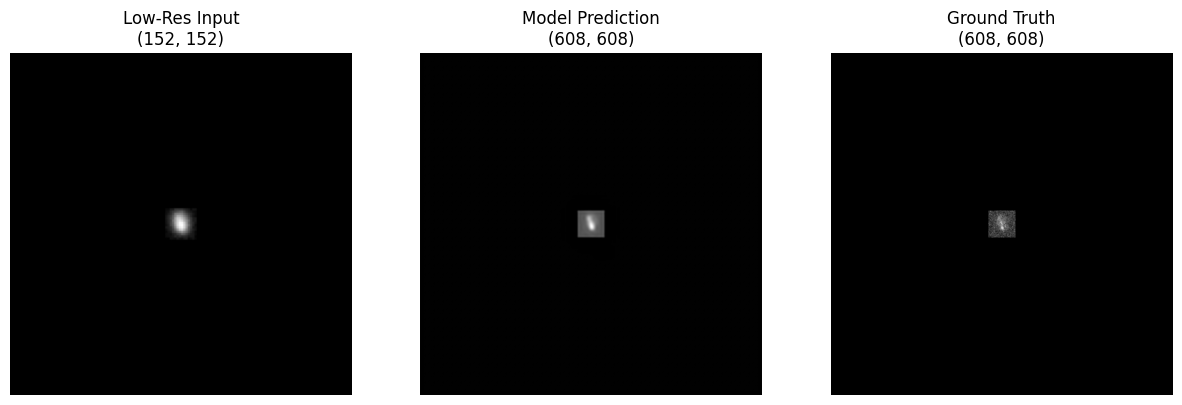

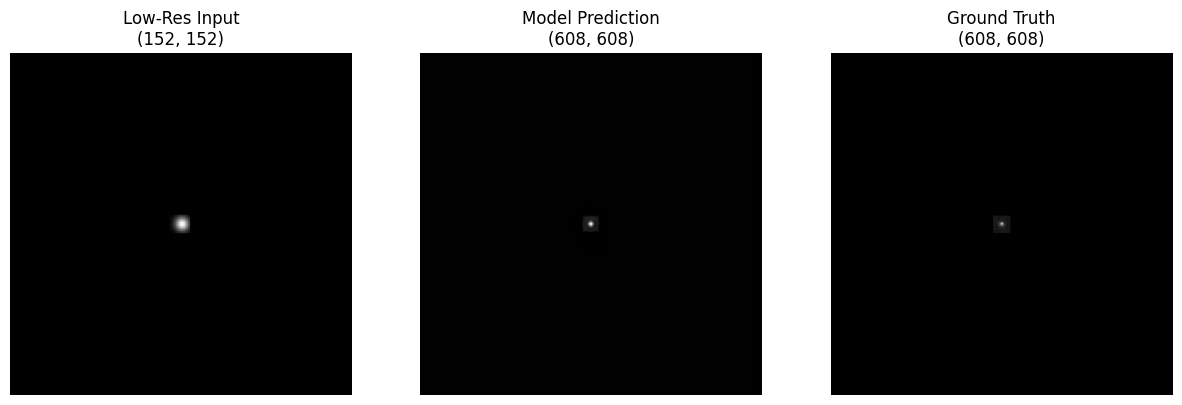

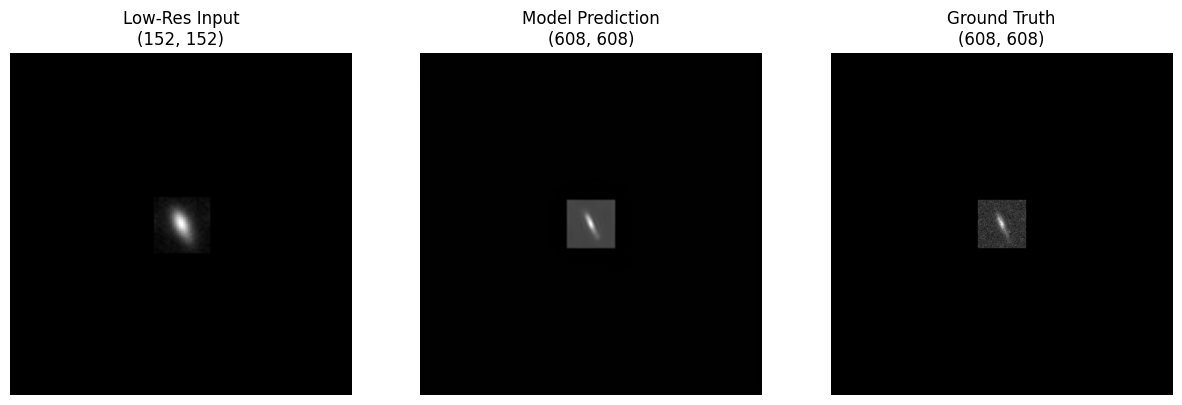

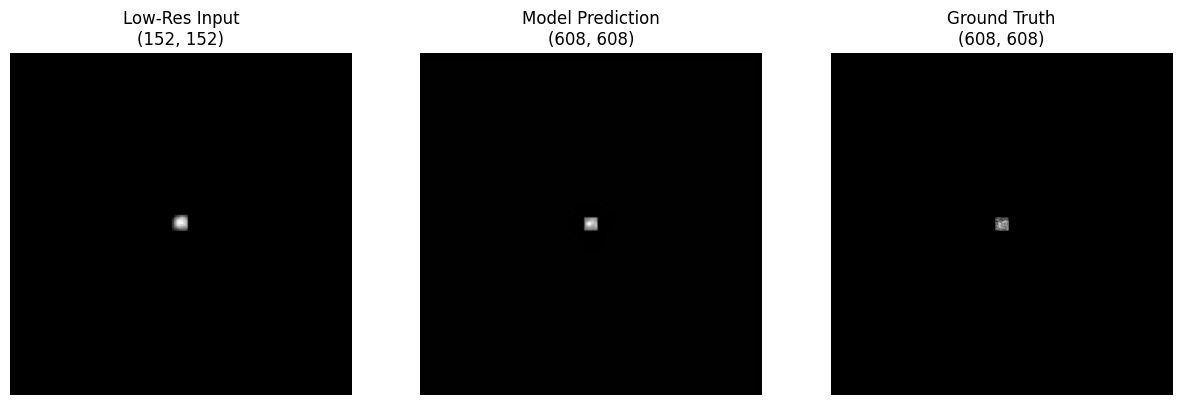

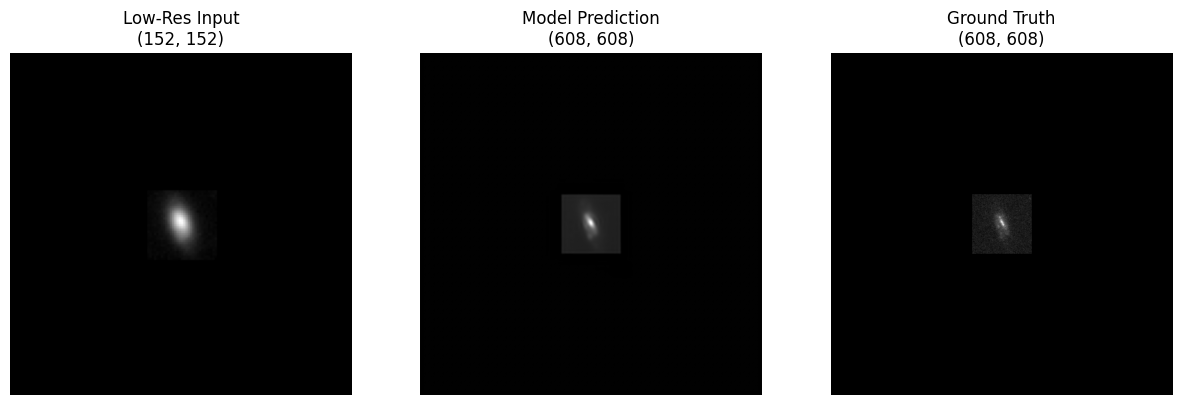

In [ ]:
# Visualizar resultados en el conjunto de test
visualize_results(ddpm_model_superres, test_loader, num_examples=5)

# PReLU

In [ ]:
#No ruido
import os
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn

from torchvision.transforms import functional as TVF  # Para transformaciones de imagen
import torch.nn.functional as F  # Para funciones de pérdida
from torch.utils.data import Dataset  # Añade esto si falta

class DDPM_SuperRes_Wrapper_PReLU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1, init=0.1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1, init=0.1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.PReLU(num_parameters=1, init=0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)
#===================================================================

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)  # Cambiado
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)  # Cambiado
        return {
            'lr': self.transform(lr_gray),
            'hr': self.transform(hr_gray)
        }

train_dataset = SRDataset(
    hr_dir='/content/split_data/train/acs/',
    lr_dir='/content/split_data/train/dud/'
)

val_dataset = SRDataset(
    hr_dir='/content/split_data/val/acs/',
    lr_dir='/content/split_data/val/dud/'
)

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

# =================================================================================

# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion PReLU"

# Crear directorio si no existe
os.makedirs(save_dir, exist_ok=True)

# Hiperparámetros
num_epochs = 100
lr = 1e-3

# Modelo y optimizador
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=lr,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
).to(device)

ddpm_model_superres = DDPM_SuperRes_Wrapper_PReLU(ddpm_model).to(device)
optimizer = torch.optim.Adam(ddpm_model_superres.parameters(), lr=lr)

# Entrenamiento
best_val_loss = float('inf')
history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': []
}

for epoch in range(num_epochs):
    ddpm_model_superres.train()
    train_losses = []

    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for batch in train_pbar:
        x_lr = batch["lr"].to(device)
        x_hr = batch["hr"].to(device)

        optimizer.zero_grad()
        pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t

        # Usamos torch.nn.functional.mse_loss
        loss = F.mse_loss(pred_hr, x_hr)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_pbar.set_postfix({'loss': loss.item()})

    # Validación
    ddpm_model_superres.eval()
    val_losses = []

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        for batch in val_pbar:
            x_lr = batch["lr"].to(device)
            x_hr = batch["hr"].to(device)

            pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t
            val_loss = F.mse_loss(pred_hr, x_hr)
            val_losses.append(val_loss.item())
            val_pbar.set_postfix({'val_loss': val_loss.item()})

    # Calcular métricas
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)

    # Guardar histórico
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    # Guardar estadísticas en CSV
    stats_df = pd.DataFrame(history)
    stats_df.to_csv(os.path.join(save_dir, 'training_stats.csv'), index=False)

    # Guardar modelo cada época
    epoch_model_path = os.path.join(save_dir, f'model_epoch_{epoch+1:03d}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': ddpm_model_superres.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, epoch_model_path)

    # Guardar mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': ddpm_model_superres.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, best_model_path)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

print("¡Entrenamiento completado!")

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


Epoch 1/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.49it/s, val_loss=0.000109]


Epoch 1/100 | Train Loss: 0.0021 | Val Loss: 0.0001


Epoch 2/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.55it/s, val_loss=7.91e-5]


Epoch 2/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 3/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 125.10it/s, val_loss=0.0002]


Epoch 3/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 4/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.91it/s, val_loss=0.000104]


Epoch 4/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 5/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.90it/s, val_loss=9.62e-5]


Epoch 5/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 6/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.33it/s, val_loss=6.13e-5]


Epoch 6/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 7/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.79it/s, val_loss=7.55e-5]


Epoch 7/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 8/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 126.04it/s, val_loss=6.45e-5]


Epoch 8/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 9/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.49it/s, val_loss=6.33e-5]


Epoch 9/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 10/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.77it/s, val_loss=7.02e-5]


Epoch 10/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 11/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.30it/s, val_loss=7.8e-5]


Epoch 11/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 12/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.49it/s, val_loss=6.5e-5]


Epoch 12/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 13/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.46it/s, val_loss=6.59e-5]


Epoch 13/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 14/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.88it/s, val_loss=7.57e-5]


Epoch 14/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 15/100 [Val]: 100%|██████████| 12891/12891 [01:41<00:00, 126.38it/s, val_loss=7.29e-5]


Epoch 15/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 16/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.81it/s, val_loss=6.91e-5]


Epoch 16/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 17/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.60it/s, val_loss=6.77e-5]


Epoch 17/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 18/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.26it/s, val_loss=7.27e-5]


Epoch 18/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 19/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.77it/s, val_loss=6.81e-5]


Epoch 19/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 20/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.81it/s, val_loss=6.69e-5]


Epoch 20/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 21/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.23it/s, val_loss=7.32e-5]


Epoch 21/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 22/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.68it/s, val_loss=6.93e-5]


Epoch 22/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 23/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.25it/s, val_loss=7.64e-5]


Epoch 23/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 24/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.54it/s, val_loss=6.32e-5]


Epoch 24/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 25/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.24it/s, val_loss=6.53e-5]


Epoch 25/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 26/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.33it/s, val_loss=6.31e-5]


Epoch 26/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 27/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.22it/s, val_loss=7.12e-5]


Epoch 27/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 28/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.20it/s, val_loss=6.74e-5]


Epoch 28/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 29/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.84it/s, val_loss=7.29e-5]


Epoch 29/100 | Train Loss: 0.0001 | Val Loss: 0.0001


Epoch 30/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.32it/s, val_loss=5.72e-5]


Epoch 30/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 31/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.78it/s, val_loss=6.09e-5]


Epoch 31/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 32/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.42it/s, val_loss=5.74e-5]


Epoch 32/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 33/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.04it/s, val_loss=6.58e-5]


Epoch 33/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 34/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.82it/s, val_loss=6.07e-5]


Epoch 34/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 35/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.20it/s, val_loss=7.71e-5]


Epoch 35/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 36/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.75it/s, val_loss=6.86e-5]


Epoch 36/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 37/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.70it/s, val_loss=7.82e-5]


Epoch 37/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 38/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.96it/s, val_loss=5.81e-5]


Epoch 38/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 39/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.97it/s, val_loss=6.32e-5]


Epoch 39/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 40/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.34it/s, val_loss=7.06e-5]


Epoch 40/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 41/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.29it/s, val_loss=6.77e-5]


Epoch 41/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 42/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.27it/s, val_loss=6.64e-5]


Epoch 42/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 43/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 125.10it/s, val_loss=7.14e-5]


Epoch 43/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 44/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.36it/s, val_loss=5.95e-5]


Epoch 44/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 45/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.86it/s, val_loss=7.38e-5]


Epoch 45/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 46/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.33it/s, val_loss=7.86e-5]


Epoch 46/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 47/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.67it/s, val_loss=7.15e-5]


Epoch 47/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 48/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.91it/s, val_loss=5.53e-5]


Epoch 48/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 49/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.75it/s, val_loss=7.62e-5]


Epoch 49/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 50/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.49it/s, val_loss=6.55e-5]


Epoch 50/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 51/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.26it/s, val_loss=7.6e-5]


Epoch 51/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 52/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.55it/s, val_loss=7.85e-5]


Epoch 52/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 53/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.75it/s, val_loss=5.54e-5]


Epoch 53/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 54/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.60it/s, val_loss=5.79e-5]


Epoch 54/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 55/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.93it/s, val_loss=5.31e-5]


Epoch 55/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 56/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.93it/s, val_loss=5.44e-5]


Epoch 56/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 57/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 125.04it/s, val_loss=6.98e-5]


Epoch 57/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 58/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.25it/s, val_loss=5.54e-5]


Epoch 58/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 59/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.94it/s, val_loss=7.22e-5]


Epoch 59/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 60/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.41it/s, val_loss=6.28e-5]


Epoch 60/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 61/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.34it/s, val_loss=6e-5]


Epoch 61/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 62/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.66it/s, val_loss=5.28e-5]


Epoch 62/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 63/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 125.03it/s, val_loss=8.55e-5]


Epoch 63/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 64/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.44it/s, val_loss=5.48e-5]


Epoch 64/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 65/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.91it/s, val_loss=8.38e-5]


Epoch 65/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 66/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.53it/s, val_loss=9.61e-5]


Epoch 66/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 67/100 [Val]: 100%|██████████| 12891/12891 [01:42<00:00, 125.21it/s, val_loss=6.98e-5]


Epoch 67/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 68/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.04it/s, val_loss=6.01e-5]


Epoch 68/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 69/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 122.95it/s, val_loss=9.42e-5]


Epoch 69/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 70/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.03it/s, val_loss=8.25e-5]


Epoch 70/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 71/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 122.83it/s, val_loss=6.59e-5]


Epoch 71/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 72/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.28it/s, val_loss=6.59e-5]


Epoch 72/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 73/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.42it/s, val_loss=9.06e-5]


Epoch 73/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 74/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.91it/s, val_loss=5.66e-5]


Epoch 74/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 75/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.53it/s, val_loss=7.59e-5]


Epoch 75/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 76/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.46it/s, val_loss=6.14e-5]


Epoch 76/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 77/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.13it/s, val_loss=8.74e-5]


Epoch 77/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 78/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.36it/s, val_loss=9.02e-5]


Epoch 78/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 79/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.60it/s, val_loss=9.17e-5]


Epoch 79/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 80/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.85it/s, val_loss=0.000197]


Epoch 80/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 81/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 123.96it/s, val_loss=8.3e-5]


Epoch 81/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 82/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.62it/s, val_loss=0.000163]


Epoch 82/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 83/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 123.97it/s, val_loss=9.25e-5]


Epoch 83/100 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 84/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.59it/s, val_loss=8.51e-5]


Epoch 84/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 85/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.83it/s, val_loss=8.7e-5]


Epoch 85/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 86/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.84it/s, val_loss=9.34e-5]


Epoch 86/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 87/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.19it/s, val_loss=8.18e-5]


Epoch 87/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 88/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.03it/s, val_loss=9.09e-5]


Epoch 88/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 89/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.75it/s, val_loss=9.33e-5]


Epoch 89/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 90/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.39it/s, val_loss=9.29e-5]


Epoch 90/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 91/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.15it/s, val_loss=9.41e-5]


Epoch 91/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 92/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.03it/s, val_loss=6.58e-5]


Epoch 92/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 93/100 [Val]: 100%|██████████| 12891/12891 [01:45<00:00, 122.30it/s, val_loss=9.22e-5]


Epoch 93/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 94/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.37it/s, val_loss=6.24e-5]


Epoch 94/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 95/100 [Val]: 100%|██████████| 12891/12891 [01:43<00:00, 124.06it/s, val_loss=5.1e-5]


Epoch 95/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 96/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.11it/s, val_loss=6.88e-5]


Epoch 96/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 97/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.78it/s, val_loss=9.09e-5]


Epoch 97/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 98/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.19it/s, val_loss=9e-5]


Epoch 98/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 99/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.54it/s, val_loss=8.52e-5]


Epoch 99/100 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 100/100 [Val]: 100%|██████████| 12891/12891 [01:44<00:00, 123.41it/s, val_loss=9.61e-5]


Epoch 100/100 | Train Loss: 0.0000 | Val Loss: 0.0000
¡Entrenamiento completado!


# Ver Resultados

In [ ]:
#No ruido
import os
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn

from torchvision.transforms import functional as TVF  # Para transformaciones de imagen
import torch.nn.functional as F  # Para funciones de pérdida
from torch.utils.data import Dataset  # Añade esto si falta


class DDPM_SuperRes_Wrapper(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )
        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)

#===================================================================

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)  # Cambiado
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)  # Cambiado
        return {
            'lr': self.transform(lr_gray),
            'hr': self.transform(hr_gray)
        }

train_dataset = SRDataset(
    hr_dir='/content/split_data/train/acs/',
    lr_dir='/content/split_data/train/dud/'
)

val_dataset = SRDataset(
    hr_dir='/content/split_data/val/acs/',
    lr_dir='/content/split_data/val/dud/'
)

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

# =================================================================================

# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion"

# Crear directorio si no existe
os.makedirs(save_dir, exist_ok=True)

# Hiperparámetros
num_epochs = 100
lr = 1e-3

# Modelo y optimizador
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=lr,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
).to(device)

ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model).to(device)
optimizer = torch.optim.Adam(ddpm_model_superres.parameters(), lr=lr)


[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
# Crear dataset de test
test_dataset = SRDataset(
    hr_dir='/content/split_data/test/acs/',
    lr_dir='/content/split_data/test/dud/'
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(model, dataloader, num_examples=3):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_examples:
                break

            x_lr = batch["lr"].to(device)
            x_hr = batch["hr"].to(device)

            # Generar predicción
            t = torch.zeros(1, dtype=torch.long, device=device)  # Usamos t=0 para generación
            pred = model(x_lr, t)

            # Convertir a numpy y desnormalizar si es necesario
            lr_img = x_lr[0].cpu().numpy().squeeze()
            hr_img = x_hr[0].cpu().numpy().squeeze()
            pred_img = pred[0].cpu().numpy().squeeze()

            # Visualizar
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(lr_img, cmap='gray')
            plt.title(f'Low-Res Input\n{lr_img.shape}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(pred_img, cmap='gray')
            plt.title(f'Model Prediction\n{pred_img.shape}')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(hr_img, cmap='gray')
            plt.title(f'Ground Truth\n{hr_img.shape}')
            plt.axis('off')

            plt.show()


In [ ]:
# Cargar el mejor modelo guardado
checkpoint = torch.load(os.path.join(save_dir, 'best_model.pth'))
ddpm_model_superres.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

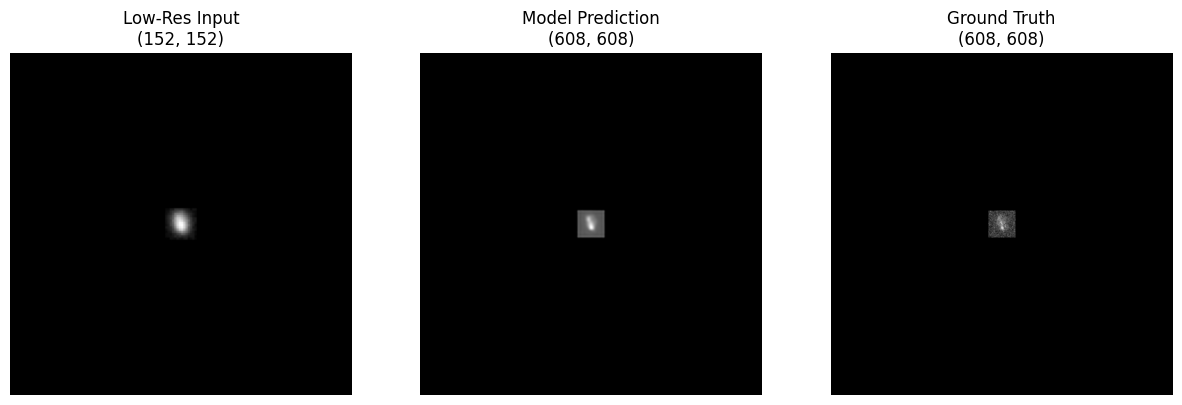

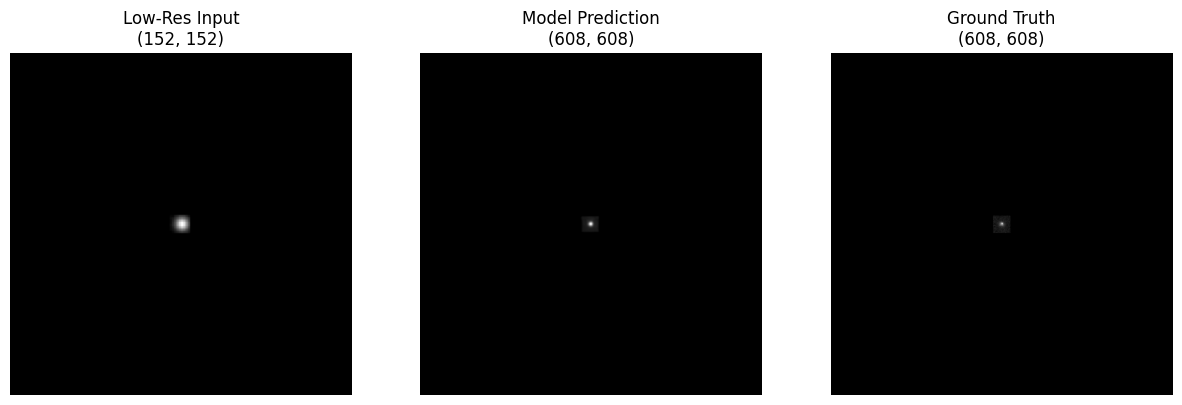

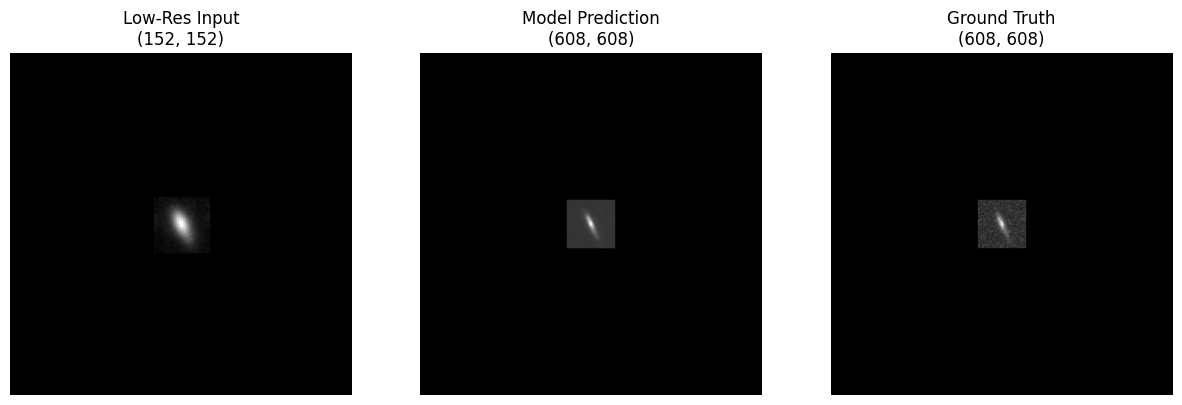

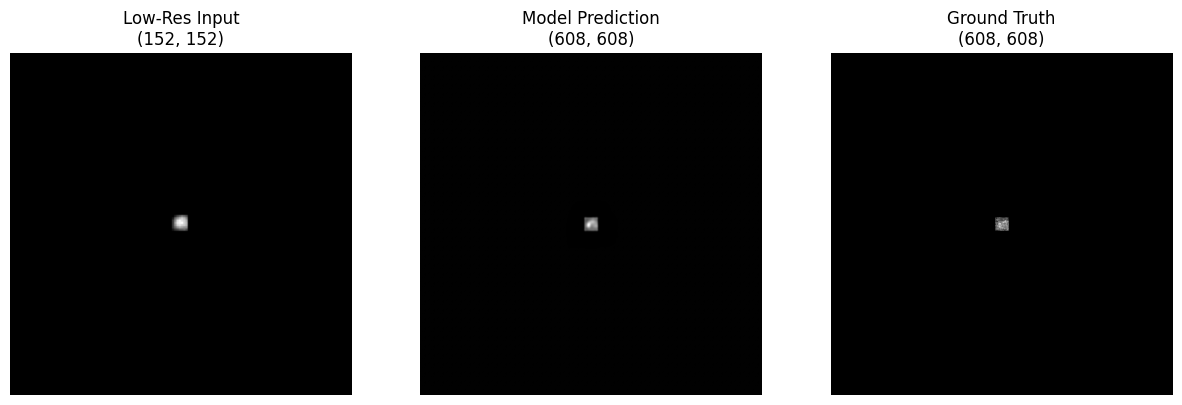

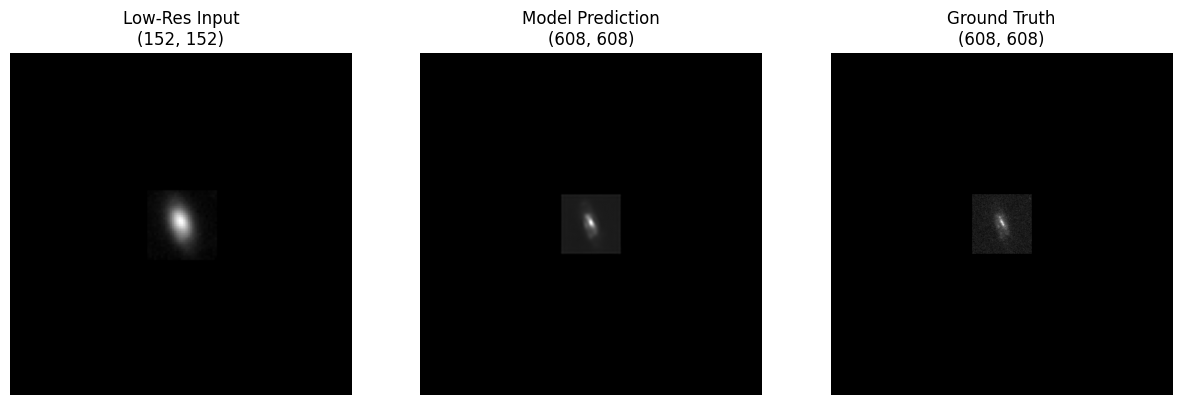

In [ ]:
# Visualizar resultados en el conjunto de test
visualize_results(ddpm_model_superres, test_loader, num_examples=5)

# Gráfico entreanmiento

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


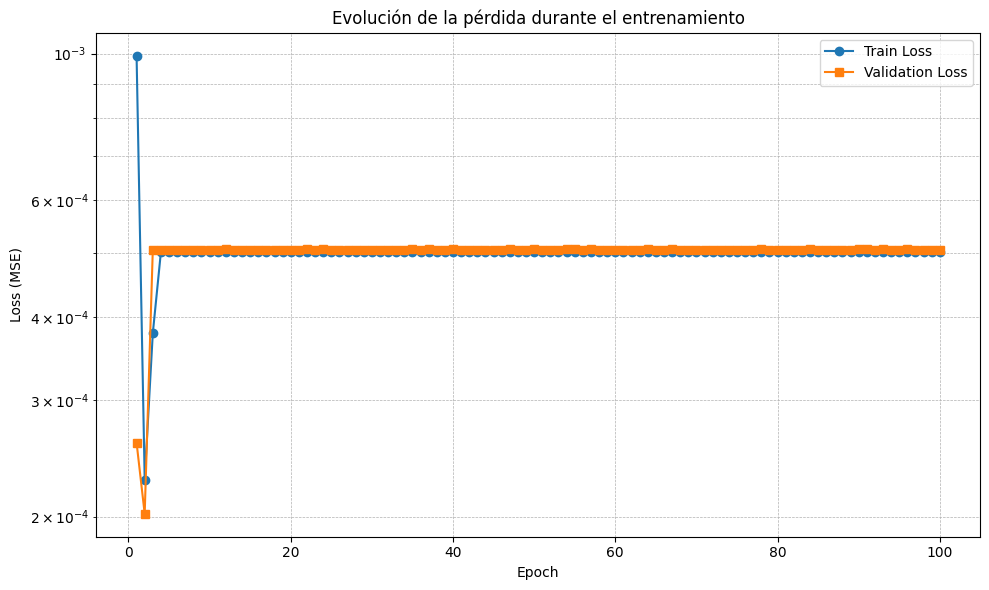

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive

drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/training_stats.csv"
history = pd.read_csv(csv_path)

plt.figure(figsize=(10,6))
plt.plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.yscale('log')  # Escala logarítmica para mejorar la visibilidad
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

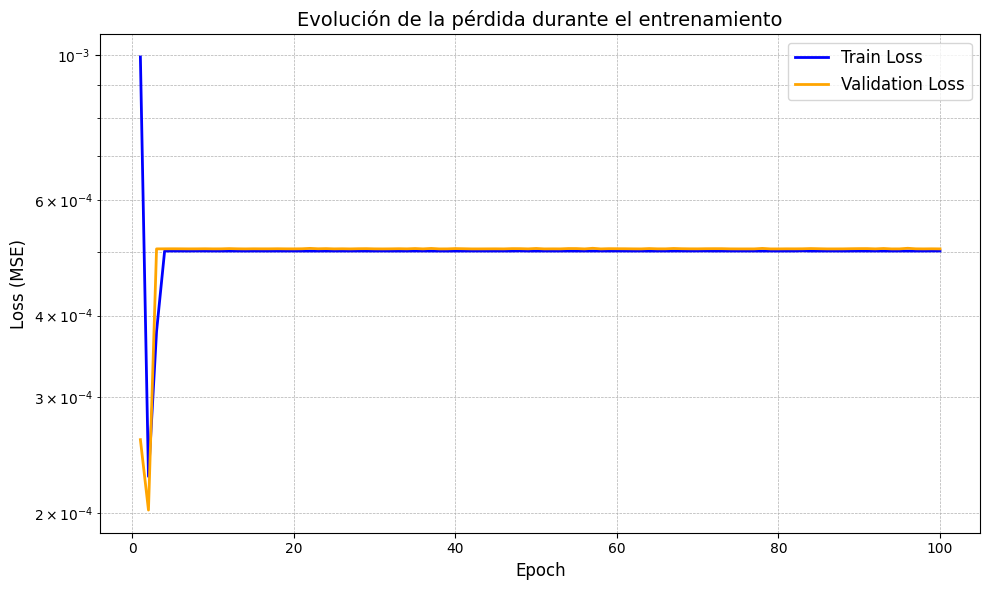

In [ ]:
# Cargar CSV
csv_path = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/training_stats.csv"
history = pd.read_csv(csv_path)

plt.figure(figsize=(10,6))

# Líneas suaves sin marcadores
plt.plot(history['epoch'], history['train_loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Evolución de la pérdida durante el entrenamiento', fontsize=14)
plt.yscale('log')  # Escala logarítmica para ver bien la evolución
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

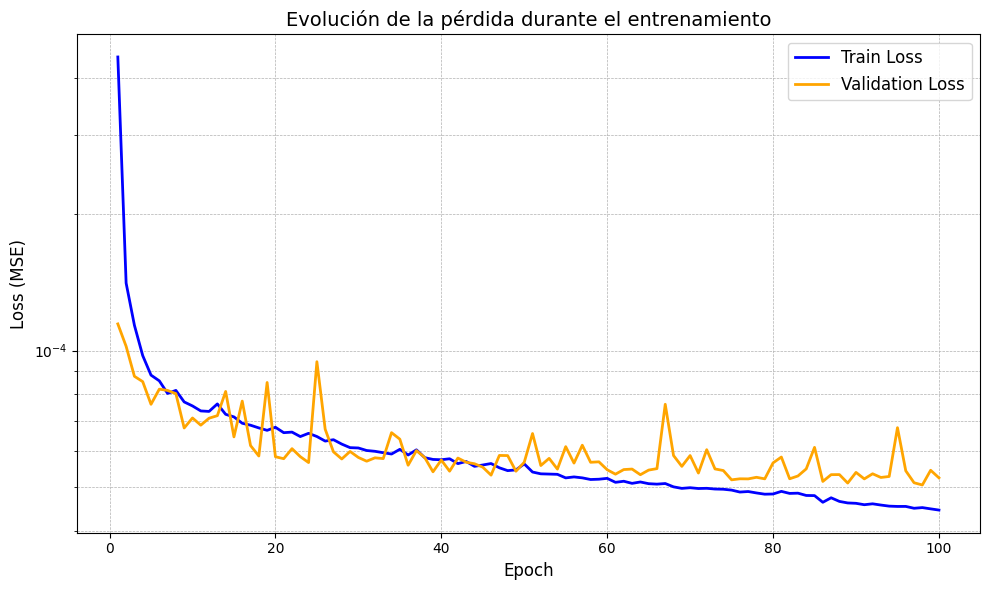

In [ ]:
# Cargar CSV
csv_path = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion ELU/training_stats.csv"
history = pd.read_csv(csv_path)

plt.figure(figsize=(10,6))

# Líneas suaves sin marcadores
plt.plot(history['epoch'], history['train_loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Evolución de la pérdida durante el entrenamiento', fontsize=14)
plt.yscale('log')  # Escala logarítmica para ver bien la evolución
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

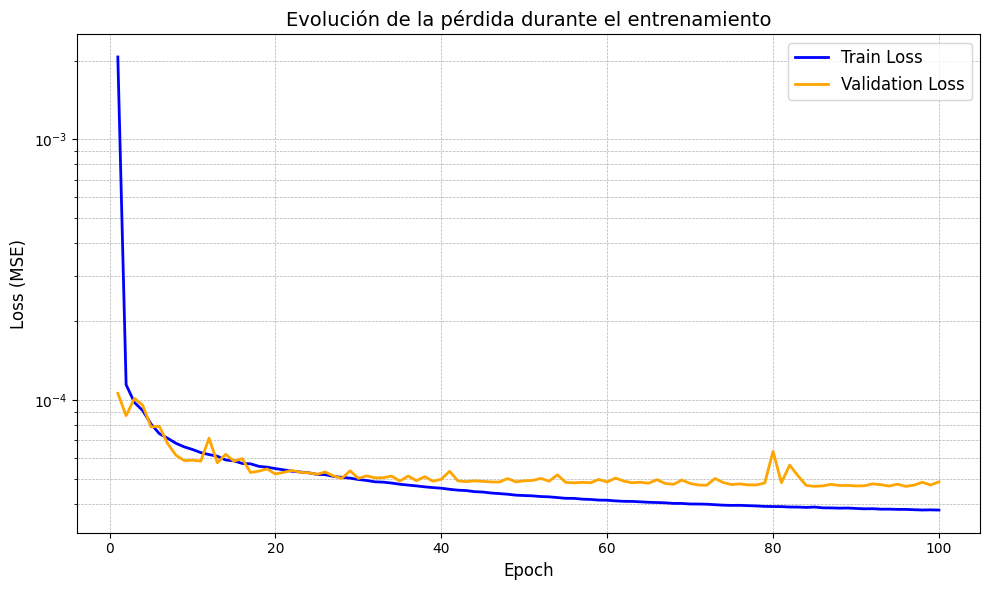

In [ ]:
# Cargar CSV
csv_path = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion PReLU/training_stats.csv"
history = pd.read_csv(csv_path)

plt.figure(figsize=(10,6))

# Líneas suaves sin marcadores
plt.plot(history['epoch'], history['train_loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Evolución de la pérdida durante el entrenamiento', fontsize=14)
plt.yscale('log')  # Escala logarítmica para ver bien la evolución
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Analisis Benchmark

In [ ]:
!pip install lpips


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import os
import glob
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
import lpips
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn

from torchvision.transforms import functional as TVF  # Para transformaciones de imagen
import torch.nn.functional as F  # Para funciones de pérdida
from torch.utils.data import Dataset  # Añade esto si falta



class DDPM_SuperRes_Wrapper(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )
        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)


class DDPM_SuperRes_Wrapper_ELU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.ELU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)

class DDPM_SuperRes_Wrapper_PReLU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.PReLU(num_parameters=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)
#===================================================================

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)  # Cambiado
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)  # Cambiado
        return {
            'lr': self.transform(lr_gray),
            'hr': self.transform(hr_gray)
        }

# Crear dataset de test
test_dataset = SRDataset(
    hr_dir='/content/split_data/test/acs/',
    lr_dir='/content/split_data/test/dud/'
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# =================================================================================

# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorio de modelos
save_dir = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion"


# Hiperparámetros
num_epochs = 100
lr = 1e-3

# Modelo y optimizador
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=lr,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
).to(device)

ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model).to(device)

# Obtener lista de modelos (incluye los 100 checkpoints y best_model.pth)
model_paths = sorted(glob.glob(os.path.join(save_dir, "model_epoch_*.pth")))
best_model_path = os.path.join(save_dir, "best_model.pth")
if os.path.exists(best_model_path):
    model_paths.append(best_model_path)

print(f"Se encontraron {len(model_paths)} modelos")

# Definir perceptual loss LPIPS
lpips_alex = lpips.LPIPS(net='alex').to(device)

# DataFrame para resultados
all_results = []

# Evaluar cada modelo
for model_path in model_paths:
    print(f"\nEvaluando modelo: {os.path.basename(model_path)}")

    # Cargar modelo
    checkpoint = torch.load(model_path, map_location=device)
    ddpm_model_superres.load_state_dict(checkpoint['model_state_dict'])
    ddpm_model_superres.eval()

    # Inicializar métricas acumuladas
    mae_list, mse_list, psnr_list, ssim_list, lpips_list = [], [], [], [], []

    with torch.no_grad():
      for batch in tqdm(test_loader, desc=f"Test {os.path.basename(model_path)}"):
          x_lr = batch["lr"].to(device)
          x_hr = batch["hr"].to(device)

          # Predicción
          pred_hr = ddpm_model_superres(x_lr)

          # Convertir a numpy
          pred_np = pred_hr.squeeze().cpu().numpy()
          hr_np = x_hr.squeeze().cpu().numpy()

          # Calcular métricas
          mae_list.append(np.mean(np.abs(hr_np - pred_np)))  # <-- MAE corregido
          mse_list.append(mean_squared_error(hr_np, pred_np))
          psnr_list.append(peak_signal_noise_ratio(hr_np, pred_np, data_range=1.0))
          ssim_list.append(structural_similarity(hr_np, pred_np, data_range=1.0))

          # LPIPS (repetimos canales porque es grayscale)
          hr_lpips = x_hr.repeat(1, 3, 1, 1).to(device)
          pred_lpips = pred_hr.repeat(1, 3, 1, 1).to(device)
          lpips_val = lpips_alex(hr_lpips, pred_lpips).item()
          lpips_list.append(lpips_val)


    # Guardar promedio de métricas de este modelo
    all_results.append({
        "model": os.path.basename(model_path),
        "MAE": sum(mae_list) / len(mae_list),
        "MSE": sum(mse_list) / len(mse_list),
        "PSNR": sum(psnr_list) / len(psnr_list),
        "SSIM": sum(ssim_list) / len(ssim_list),
        "LPIPS": sum(lpips_list) / len(lpips_list),
    })

# Guardar todos los resultados en CSV
results_df = pd.DataFrame(all_results)
results_path = os.path.join(save_dir, "all_models_test_metrics.csv")
results_df.to_csv(results_path, index=False)

print(f"\n✅ Evaluación completada. Resultados guardados en {results_path}")
print(results_df)


[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32
Se encontraron 101 modelos
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth

Evaluando modelo: model_epoch_001.pth


Test model_epoch_001.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.31it/s]



Evaluando modelo: model_epoch_002.pth


Test model_epoch_002.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.32it/s]



Evaluando modelo: model_epoch_003.pth


Test model_epoch_003.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.41it/s]



Evaluando modelo: model_epoch_004.pth


Test model_epoch_004.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.33it/s]



Evaluando modelo: model_epoch_005.pth


Test model_epoch_005.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.33it/s]



Evaluando modelo: model_epoch_006.pth


Test model_epoch_006.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_007.pth


Test model_epoch_007.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.30it/s]



Evaluando modelo: model_epoch_008.pth


Test model_epoch_008.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.35it/s]



Evaluando modelo: model_epoch_009.pth


Test model_epoch_009.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.40it/s]



Evaluando modelo: model_epoch_010.pth


Test model_epoch_010.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.41it/s]



Evaluando modelo: model_epoch_011.pth


Test model_epoch_011.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.29it/s]



Evaluando modelo: model_epoch_012.pth


Test model_epoch_012.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.19it/s]



Evaluando modelo: model_epoch_013.pth


Test model_epoch_013.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.18it/s]



Evaluando modelo: model_epoch_014.pth


Test model_epoch_014.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.12it/s]



Evaluando modelo: model_epoch_015.pth


Test model_epoch_015.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.11it/s]



Evaluando modelo: model_epoch_016.pth


Test model_epoch_016.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.23it/s]



Evaluando modelo: model_epoch_017.pth


Test model_epoch_017.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.30it/s]



Evaluando modelo: model_epoch_018.pth


Test model_epoch_018.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.23it/s]



Evaluando modelo: model_epoch_019.pth


Test model_epoch_019.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.40it/s]



Evaluando modelo: model_epoch_020.pth


Test model_epoch_020.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.15it/s]



Evaluando modelo: model_epoch_021.pth


Test model_epoch_021.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.32it/s]



Evaluando modelo: model_epoch_022.pth


Test model_epoch_022.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.28it/s]



Evaluando modelo: model_epoch_023.pth


Test model_epoch_023.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.15it/s]



Evaluando modelo: model_epoch_024.pth


Test model_epoch_024.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.10it/s]



Evaluando modelo: model_epoch_025.pth


Test model_epoch_025.pth: 100%|██████████| 12892/12892 [08:14<00:00, 26.10it/s]



Evaluando modelo: model_epoch_026.pth


Test model_epoch_026.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.22it/s]



Evaluando modelo: model_epoch_027.pth


Test model_epoch_027.pth: 100%|██████████| 12892/12892 [08:14<00:00, 26.05it/s]



Evaluando modelo: model_epoch_028.pth


Test model_epoch_028.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.20it/s]



Evaluando modelo: model_epoch_029.pth


Test model_epoch_029.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.16it/s]



Evaluando modelo: model_epoch_030.pth


Test model_epoch_030.pth: 100%|██████████| 12892/12892 [08:16<00:00, 25.98it/s]



Evaluando modelo: model_epoch_031.pth


Test model_epoch_031.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.12it/s]



Evaluando modelo: model_epoch_032.pth


Test model_epoch_032.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.30it/s]



Evaluando modelo: model_epoch_033.pth


Test model_epoch_033.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.12it/s]



Evaluando modelo: model_epoch_034.pth


Test model_epoch_034.pth: 100%|██████████| 12892/12892 [08:15<00:00, 26.01it/s]



Evaluando modelo: model_epoch_035.pth


Test model_epoch_035.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_036.pth


Test model_epoch_036.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.10it/s]



Evaluando modelo: model_epoch_037.pth


Test model_epoch_037.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.20it/s]



Evaluando modelo: model_epoch_038.pth


Test model_epoch_038.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.37it/s]



Evaluando modelo: model_epoch_039.pth


Test model_epoch_039.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.28it/s]



Evaluando modelo: model_epoch_040.pth


Test model_epoch_040.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.32it/s]



Evaluando modelo: model_epoch_041.pth


Test model_epoch_041.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.28it/s]



Evaluando modelo: model_epoch_042.pth


Test model_epoch_042.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.20it/s]



Evaluando modelo: model_epoch_043.pth


Test model_epoch_043.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.22it/s]



Evaluando modelo: model_epoch_044.pth


Test model_epoch_044.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.21it/s]



Evaluando modelo: model_epoch_045.pth


Test model_epoch_045.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.31it/s]



Evaluando modelo: model_epoch_046.pth


Test model_epoch_046.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.23it/s]



Evaluando modelo: model_epoch_047.pth


Test model_epoch_047.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.24it/s]



Evaluando modelo: model_epoch_048.pth


Test model_epoch_048.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.23it/s]



Evaluando modelo: model_epoch_049.pth


Test model_epoch_049.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.16it/s]



Evaluando modelo: model_epoch_050.pth


Test model_epoch_050.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.28it/s]



Evaluando modelo: model_epoch_051.pth


Test model_epoch_051.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.12it/s]



Evaluando modelo: model_epoch_052.pth


Test model_epoch_052.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.16it/s]



Evaluando modelo: model_epoch_053.pth


Test model_epoch_053.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.18it/s]



Evaluando modelo: model_epoch_054.pth


Test model_epoch_054.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.15it/s]



Evaluando modelo: model_epoch_055.pth


Test model_epoch_055.pth: 100%|██████████| 12892/12892 [08:14<00:00, 26.08it/s]



Evaluando modelo: model_epoch_056.pth


Test model_epoch_056.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.20it/s]



Evaluando modelo: model_epoch_057.pth


Test model_epoch_057.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.16it/s]



Evaluando modelo: model_epoch_058.pth


Test model_epoch_058.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.21it/s]



Evaluando modelo: model_epoch_059.pth


Test model_epoch_059.pth: 100%|██████████| 12892/12892 [08:13<00:00, 26.14it/s]



Evaluando modelo: model_epoch_060.pth


Test model_epoch_060.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.19it/s]



Evaluando modelo: model_epoch_061.pth


Test model_epoch_061.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.26it/s]



Evaluando modelo: model_epoch_062.pth


Test model_epoch_062.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.21it/s]



Evaluando modelo: model_epoch_063.pth


Test model_epoch_063.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.17it/s]



Evaluando modelo: model_epoch_064.pth


Test model_epoch_064.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.29it/s]



Evaluando modelo: model_epoch_065.pth


Test model_epoch_065.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.18it/s]



Evaluando modelo: model_epoch_066.pth


Test model_epoch_066.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.20it/s]



Evaluando modelo: model_epoch_067.pth


Test model_epoch_067.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.20it/s]



Evaluando modelo: model_epoch_068.pth


Test model_epoch_068.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.17it/s]



Evaluando modelo: model_epoch_069.pth


Test model_epoch_069.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.27it/s]



Evaluando modelo: model_epoch_070.pth


Test model_epoch_070.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.38it/s]



Evaluando modelo: model_epoch_071.pth


Test model_epoch_071.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.21it/s]



Evaluando modelo: model_epoch_072.pth


Test model_epoch_072.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.36it/s]



Evaluando modelo: model_epoch_073.pth


Test model_epoch_073.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.32it/s]



Evaluando modelo: model_epoch_074.pth


Test model_epoch_074.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.33it/s]



Evaluando modelo: model_epoch_075.pth


Test model_epoch_075.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.36it/s]



Evaluando modelo: model_epoch_076.pth


Test model_epoch_076.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.28it/s]



Evaluando modelo: model_epoch_077.pth


Test model_epoch_077.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.37it/s]



Evaluando modelo: model_epoch_078.pth


Test model_epoch_078.pth: 100%|██████████| 12892/12892 [08:07<00:00, 26.43it/s]



Evaluando modelo: model_epoch_079.pth


Test model_epoch_079.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_080.pth


Test model_epoch_080.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.33it/s]



Evaluando modelo: model_epoch_081.pth


Test model_epoch_081.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.38it/s]



Evaluando modelo: model_epoch_082.pth


Test model_epoch_082.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.27it/s]



Evaluando modelo: model_epoch_083.pth


Test model_epoch_083.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.29it/s]



Evaluando modelo: model_epoch_084.pth


Test model_epoch_084.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.30it/s]



Evaluando modelo: model_epoch_085.pth


Test model_epoch_085.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_086.pth


Test model_epoch_086.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.30it/s]



Evaluando modelo: model_epoch_087.pth


Test model_epoch_087.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.26it/s]



Evaluando modelo: model_epoch_088.pth


Test model_epoch_088.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.31it/s]



Evaluando modelo: model_epoch_089.pth


Test model_epoch_089.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.27it/s]



Evaluando modelo: model_epoch_090.pth


Test model_epoch_090.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_091.pth


Test model_epoch_091.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.30it/s]



Evaluando modelo: model_epoch_092.pth


Test model_epoch_092.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_093.pth


Test model_epoch_093.pth: 100%|██████████| 12892/12892 [08:12<00:00, 26.16it/s]



Evaluando modelo: model_epoch_094.pth


Test model_epoch_094.pth: 100%|██████████| 12892/12892 [08:11<00:00, 26.25it/s]



Evaluando modelo: model_epoch_095.pth


Test model_epoch_095.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.32it/s]



Evaluando modelo: model_epoch_096.pth


Test model_epoch_096.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_097.pth


Test model_epoch_097.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.26it/s]



Evaluando modelo: model_epoch_098.pth


Test model_epoch_098.pth: 100%|██████████| 12892/12892 [08:09<00:00, 26.34it/s]



Evaluando modelo: model_epoch_099.pth


Test model_epoch_099.pth: 100%|██████████| 12892/12892 [08:10<00:00, 26.31it/s]



Evaluando modelo: model_epoch_100.pth


Test model_epoch_100.pth: 100%|██████████| 12892/12892 [08:08<00:00, 26.37it/s]



Evaluando modelo: best_model.pth


Test best_model.pth: 100%|██████████| 12892/12892 [08:07<00:00, 26.47it/s]


✅ Evaluación completada. Resultados guardados en /content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/all_models_test_metrics.csv
                   model       MAE       MSE       PSNR      SSIM     LPIPS
0    model_epoch_001.pth  0.002061  0.000262  38.212554  0.982688  0.021518
1    model_epoch_002.pth  0.001665  0.000204  38.854443  0.982311  0.017596
2    model_epoch_003.pth  0.004098  0.000512  35.921477  0.944706  0.026328
3    model_epoch_004.pth  0.003891  0.000512  35.935992  0.951917  0.026327
4    model_epoch_005.pth  0.004698  0.000512  35.864787  0.919862  0.026323
..                   ...       ...       ...        ...       ...       ...
96   model_epoch_097.pth  0.004618  0.000512  35.873462  0.923450  0.026328
97   model_epoch_098.pth  0.004421  0.000512  35.893568  0.932012  0.026320
98   model_epoch_099.pth  0.003849  0.000513  35.938603  0.953287  0.026321
99   model_epoch_100.pth  0.004432  0.000512  35.892432  0.931518  0.026324
100       best_model

In [ ]:
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/drive')
# Cargar resultados
results_path = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/all_models_test_metrics.csv"
df = pd.read_csv(results_path)

# Identificar mejor modelo por métrica
best_models = {}

# Métricas donde menor es mejor
for metric in ["MAE", "MSE", "LPIPS"]:
    best_row = df.loc[df[metric].idxmin()]
    best_models[metric] = (best_row["model"], best_row[metric])

# Métricas donde mayor es mejor
for metric in ["PSNR", "SSIM"]:
    best_row = df.loc[df[metric].idxmax()]
    best_models[metric] = (best_row["model"], best_row[metric])

print("📊 Mejor modelo por métrica:")
for metric, (model, value) in best_models.items():
    print(f"{metric}: {model} ({value:.4f})")

# --- Mejor modelo en general ---
# Normalizamos todas las métricas para que siempre "más alto = mejor"
df_norm = df.copy()

# Normalización por min-max
for metric in ["MAE", "MSE", "LPIPS"]:
    df_norm[metric] = 1 - (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

for metric in ["PSNR", "SSIM"]:
    df_norm[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Calcular promedio de puntuación
df_norm["score"] = df_norm[["MAE", "MSE", "PSNR", "SSIM", "LPIPS"]].mean(axis=1)

# Modelo con mejor score
best_overall = df_norm.loc[df_norm["score"].idxmax()]
print("\n🏆 Mejor modelo en general:")
print(f"{best_overall['model']} (score={best_overall['score']:.4f})")


Mounted at /content/drive
📊 Mejor modelo por métrica:
MAE: model_epoch_002.pth (0.0017)
MSE: model_epoch_002.pth (0.0002)
LPIPS: model_epoch_002.pth (0.0176)
PSNR: model_epoch_002.pth (38.8544)
SSIM: model_epoch_001.pth (0.9827)

🏆 Mejor modelo en general:
model_epoch_002.pth (score=0.9992)


In [ ]:
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/drive')
# Cargar resultados
results_path = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion ELU/all_models_test_metrics.csv"
df = pd.read_csv(results_path)

# Identificar mejor modelo por métrica
best_models = {}

# Métricas donde menor es mejor
for metric in ["MAE", "MSE", "LPIPS"]:
    best_row = df.loc[df[metric].idxmin()]
    best_models[metric] = (best_row["model"], best_row[metric])

# Métricas donde mayor es mejor
for metric in ["PSNR", "SSIM"]:
    best_row = df.loc[df[metric].idxmax()]
    best_models[metric] = (best_row["model"], best_row[metric])

print("📊 Mejor modelo por métrica:")
for metric, (model, value) in best_models.items():
    print(f"{metric}: {model} ({value:.4f})")

# --- Mejor modelo en general ---
# Normalizamos todas las métricas para que siempre "más alto = mejor"
df_norm = df.copy()

# Normalización por min-max
for metric in ["MAE", "MSE", "LPIPS"]:
    df_norm[metric] = 1 - (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

for metric in ["PSNR", "SSIM"]:
    df_norm[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Calcular promedio de puntuación
df_norm["score"] = df_norm[["MAE", "MSE", "PSNR", "SSIM", "LPIPS"]].mean(axis=1)

# Modelo con mejor score
best_overall = df_norm.loc[df_norm["score"].idxmax()]
print("\n🏆 Mejor modelo en general:")
print(f"{best_overall['model']} (score={best_overall['score']:.4f})")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Mejor modelo por métrica:
MAE: model_epoch_091.pth (0.0008)
MSE: model_epoch_098.pth (0.0001)
LPIPS: model_epoch_098.pth (0.0170)
PSNR: model_epoch_089.pth (45.5736)
SSIM: model_epoch_091.pth (0.9903)

🏆 Mejor modelo en general:
model_epoch_091.pth (score=0.9806)


In [ ]:
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/drive')
# Cargar resultados
results_path = "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion PReLU/all_models_test_metrics.csv"
df = pd.read_csv(results_path)

# Identificar mejor modelo por métrica
best_models = {}

# Métricas donde menor es mejor
for metric in ["MAE", "MSE", "LPIPS"]:
    best_row = df.loc[df[metric].idxmin()]
    best_models[metric] = (best_row["model"], best_row[metric])

# Métricas donde mayor es mejor
for metric in ["PSNR", "SSIM"]:
    best_row = df.loc[df[metric].idxmax()]
    best_models[metric] = (best_row["model"], best_row[metric])

print("📊 Mejor modelo por métrica:")
for metric, (model, value) in best_models.items():
    print(f"{metric}: {model} ({value:.4f})")

# --- Mejor modelo en general ---
# Normalizamos todas las métricas para que siempre "más alto = mejor"
df_norm = df.copy()

# Normalización por min-max
for metric in ["MAE", "MSE", "LPIPS"]:
    df_norm[metric] = 1 - (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

for metric in ["PSNR", "SSIM"]:
    df_norm[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Calcular promedio de puntuación
df_norm["score"] = df_norm[["MAE", "MSE", "PSNR", "SSIM", "LPIPS"]].mean(axis=1)

# Modelo con mejor score
best_overall = df_norm.loc[df_norm["score"].idxmax()]
print("\n🏆 Mejor modelo en general:")
print(f"{best_overall['model']} (score={best_overall['score']:.4f})")


Mounted at /content/drive
📊 Mejor modelo por métrica:
MAE: model_epoch_094.pth (0.0006)
MSE: model_epoch_096.pth (0.0000)
LPIPS: model_epoch_096.pth (0.0152)
PSNR: model_epoch_090.pth (46.0855)
SSIM: model_epoch_068.pth (0.9929)

🏆 Mejor modelo en general:
model_epoch_094.pth (score=0.9957)


In [ ]:
import pandas as pd

# Definir las rutas de los tres modelos
paths = {
    "Básico": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/all_models_test_metrics.csv",
    "Normalized": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion ELU/all_models_test_metrics.csv",
    "Parametric": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion PReLU/all_models_test_metrics.csv"
}

# Diccionario para almacenar los mejores modelos de cada tipo
best_models = {}

# Función para calcular el mejor modelo según cada métrica (usando normalización)
def get_best_model(path):
    df = pd.read_csv(path)

    # Normalización de las métricas
    df_norm = df.copy()

    # Normalización por min-max
    for metric in ["MAE", "MSE", "LPIPS"]:
        df_norm[metric] = 1 - (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

    for metric in ["PSNR", "SSIM"]:
        df_norm[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

    # Calcular promedio de puntuación
    df_norm["score"] = df_norm[["MAE", "MSE", "PSNR", "SSIM", "LPIPS"]].mean(axis=1)

    # Mejor modelo en general (con el score más alto)
    best_overall = df_norm.loc[df_norm["score"].idxmax()]

    # Devolver el mejor modelo y su score
    return best_overall["model"], best_overall["score"]

# Cargar los mejores modelos para cada tipo
all_best_models = {}
for model_type, path in paths.items():
    model, score = get_best_model(path)
    all_best_models[model_type] = {
        "model": model,
        "score": score
    }

# Mostrar los nombres de los mejores modelos
print("📊 Mejor modelo en general para cada tipo:")
for model_type, model_info in all_best_models.items():
    print(f"{model_type}: {model_info['model']}")

# Crear una lista para almacenar las comparaciones
comparisons = []

# Comparar las métricas entre los mejores modelos de cada tipo
for metric in ["MAE", "MSE", "LPIPS", "PSNR", "SSIM"]:
    # Obtener los valores originales para cada modelo
    basic_value = pd.read_csv(paths["Básico"]).loc[lambda df: df["model"] == all_best_models["Básico"]["model"], metric].values[0]
    normalized_value = pd.read_csv(paths["Normalized"]).loc[lambda df: df["model"] == all_best_models["Normalized"]["model"], metric].values[0]
    parametric_value = pd.read_csv(paths["Parametric"]).loc[lambda df: df["model"] == all_best_models["Parametric"]["model"], metric].values[0]

    # Calcular las mejoras porcentuales
    if metric in ["MAE", "MSE", "LPIPS"]:  # Menor es mejor
        normalized_improvement = ((basic_value - normalized_value) / basic_value) * 100
        parametric_improvement = ((basic_value - parametric_value) / basic_value) * 100
    else:  # PSNR, SSIM (mayor es mejor)
        normalized_improvement = ((normalized_value - basic_value) / basic_value) * 100
        parametric_improvement = ((parametric_value - basic_value) / basic_value) * 100

    # Agregar la comparación a la lista
    comparisons.append({
        "Métrica": metric,
        "Valor Básico": f"{basic_value:.4f}",
        "Valor Normalized": f"{normalized_value:.4f}",
        "Valor Parametric": f"{parametric_value:.4f}",
        "Mejora Normalized (%)": f"{normalized_improvement:.2f}%",
        "Mejora Parametric (%)": f"{parametric_improvement:.2f}%"
    })

# Crear el DataFrame con las comparaciones
comparisons_df = pd.DataFrame(comparisons)

# Mostrar la tabla
print("\n📊 Comparación de Métricas entre Modelos:")
print(comparisons_df)


📊 Mejor modelo en general para cada tipo:
Básico: model_epoch_002.pth
Normalized: model_epoch_091.pth
Parametric: model_epoch_094.pth

📊 Comparación de Métricas entre Modelos:
  Métrica Valor Básico Valor Normalized Valor Parametric  \
0     MAE       0.0017           0.0008           0.0006   
1     MSE       0.0002           0.0001           0.0000   
2   LPIPS       0.0176           0.0174           0.0152   
3    PSNR      38.8544          45.4147          46.0485   
4    SSIM       0.9823           0.9903           0.9928   

  Mejora Normalized (%) Mejora Parametric (%)  
0                49.50%                62.96%  
1                74.29%                76.83%  
2                 1.23%                13.54%  
3                16.88%                18.52%  
4                 0.81%                 1.07%  


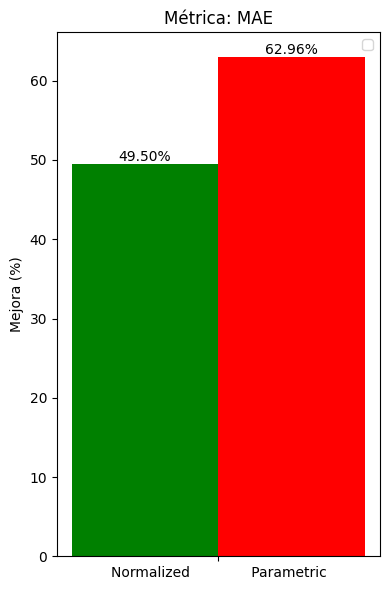

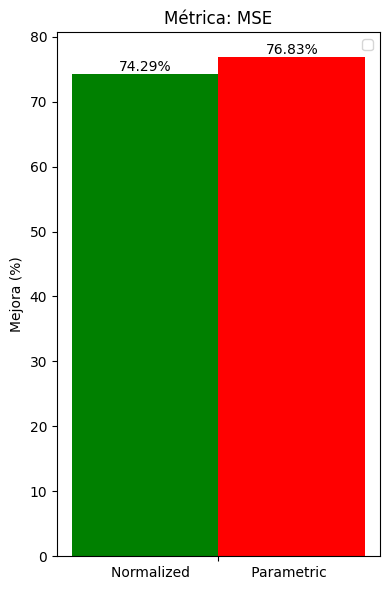

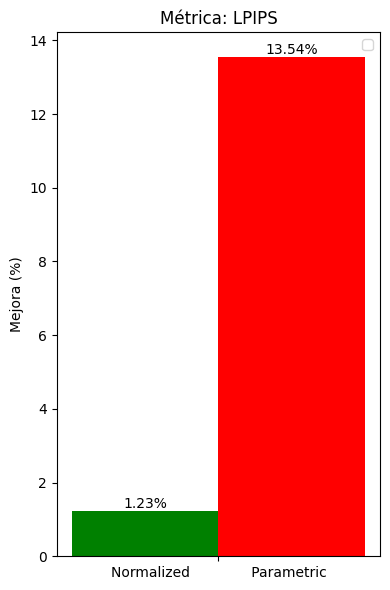

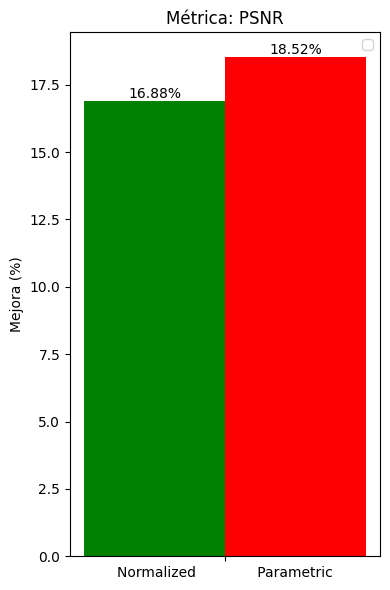

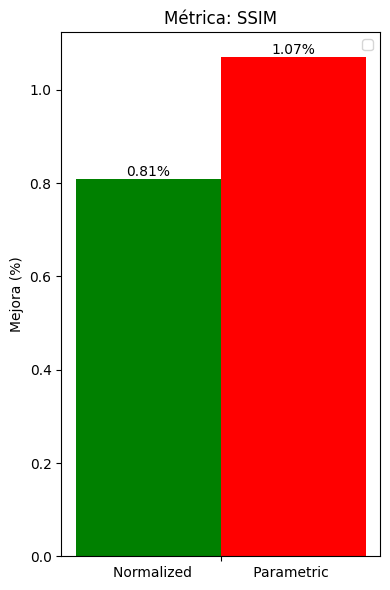

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Definir las métricas y los porcentajes de mejora
metrics = ["MAE", "MSE", "LPIPS", "PSNR", "SSIM"]
normalized_improvements = [49.50, 74.29, 1.23, 16.88, 0.81]
parametric_improvements = [62.96, 76.83, 13.54, 18.52, 1.07]

# Crear un DataFrame con los datos de mejora
df = pd.DataFrame({
    "Métrica": metrics,
    "Mejora Normalized (%)": normalized_improvements,
    "Mejora Parametric (%)": parametric_improvements
})

# Crear gráficos separados para cada métrica
for metric in metrics:
    plt.figure(figsize=(4, 6))  # Ajustamos el tamaño para hacerlo más compacto

    # Posiciones de las barras
    bar_width = 0.4  # Barra más estrecha
    index = np.arange(len(metrics))  # Un solo índice para las barras, para todas las métricas

    # Obtener los valores de mejora para cada métrica
    normalized_value = df.loc[df["Métrica"] == metric, "Mejora Normalized (%)"].values[0]
    parametric_value = df.loc[df["Métrica"] == metric, "Mejora Parametric (%)"].values[0]

    # Generar las barras para la métrica actual
    bar1 = plt.bar(index[0] - 0.2, normalized_value, bar_width, label="Normalized", color='green')
    bar2 = plt.bar(index[0] + 0.2, parametric_value, bar_width, label="Parametric", color='red')

    # Añadir etiquetas y título
    plt.title(f"Métrica: {metric}")
#    plt.xlabel("Modelos")
    plt.ylabel("Mejora (%)")
    plt.xticks([index[0]], ["Normalized              Parametric"])  # Etiqueta solo la métrica
    plt.legend([])

    # Añadir los valores encima de cada barra
    for bar in [bar1, bar2]:
        for rect in bar:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.2f}%',
                     ha='center', va='bottom', fontsize=10)

    # Ajustar el gráfico para que las barras estén más juntas
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import os
import glob
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
import lpips
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn

from torchvision.transforms import functional as TVF  # Para transformaciones de imagen
import torch.nn.functional as F  # Para funciones de pérdida
from torch.utils.data import Dataset  # Añade esto si falta

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)  # Cambiado
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)  # Cambiado
        return {
            'lr': self.transform(lr_gray),
            'hr': self.transform(hr_gray)
        }

train_dataset = SRDataset(
    hr_dir='/content/split_data/train/acs/',
    lr_dir='/content/split_data/train/dud/'
)
val_dataset = SRDataset(
    hr_dir='/content/split_data/val/acs/',
    lr_dir='/content/split_data/val/dud/'
)
test_dataset = SRDataset(
    hr_dir='/content/split_data/test/acs/',
    lr_dir='/content/split_data/test/dud/'
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

In [ ]:
class DDPM_SuperRes_Wrapper(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )
        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)


class DDPM_SuperRes_Wrapper_ELU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ELU(),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.ELU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)

class DDPM_SuperRes_Wrapper_PReLU(nn.Module):
    def __init__(self, ddpm_model):
        super().__init__()
        self.ddpm = ddpm_model

        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.PReLU(num_parameters=1),
            nn.Dropout(0.1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),

            # Capa adicional al final
            nn.PReLU(num_parameters=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )

        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):
        x_2ch = self.duplicate_channel(x)
        out = self.ddpm(x_2ch) if t is None else self.ddpm(x_2ch, t)
        return self.upscale(out)

[Básico] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


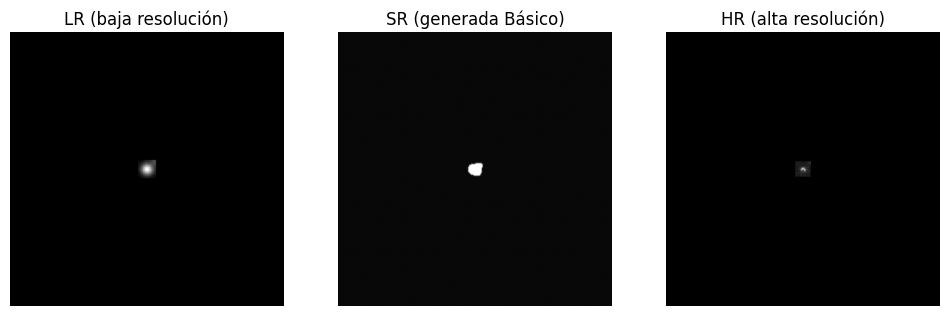

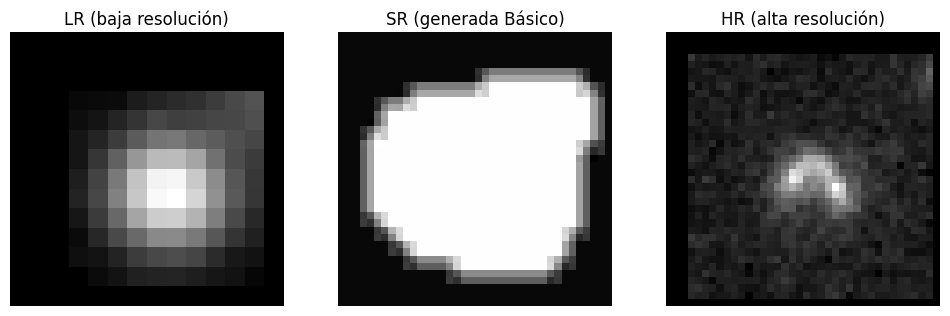

[Normalized] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


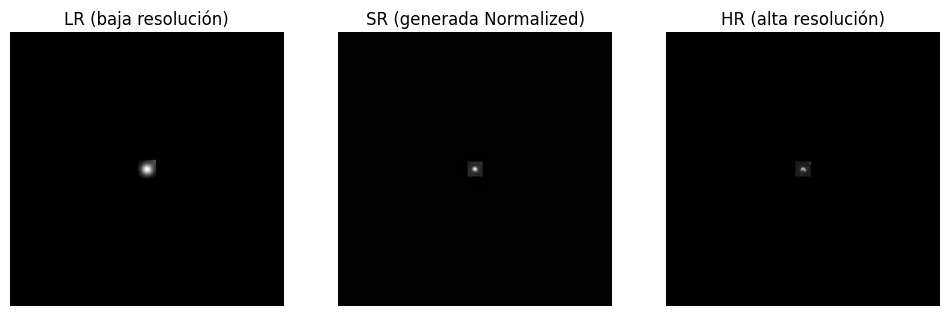

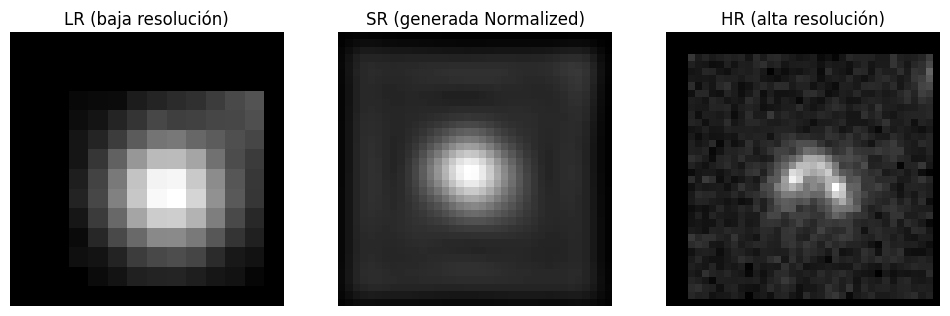

[Parametric] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


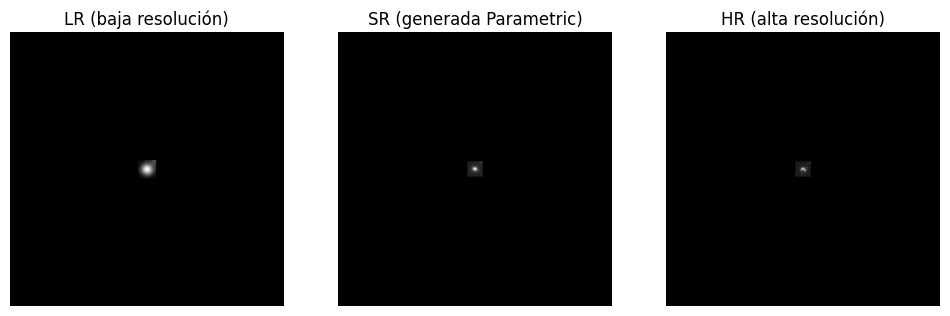

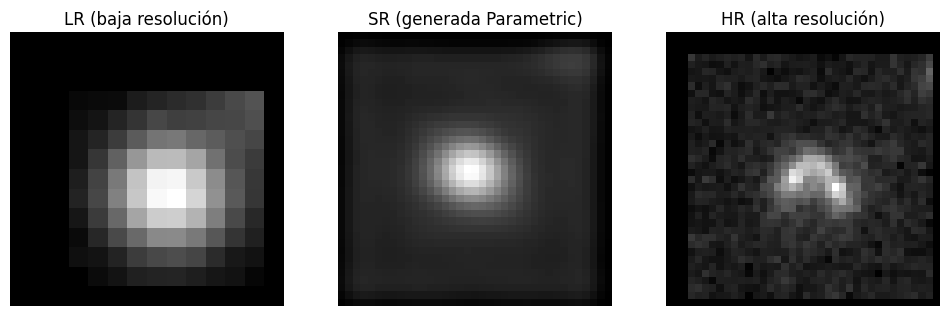

In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.transforms import functional as TVF
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import functional as TVF

def _crop_square_by_projection_np(arr, thr_ratio=0.12, pad=2, make_square=True):
    """
    Recorta el contenido brillante sobre fondo negro usando proyecciones 1D.
    - arr: imagen 2D float [0,1]
    - thr_ratio: umbral relativo (0.08–0.20 suele ir bien)
    - pad: margen en píxeles
    - make_square: ajusta el recorte a un cuadrado centrado
    """
    arr = np.asarray(arr).astype(np.float32)
    if arr.ndim == 3:
        arr = arr[..., 0]

    m = float(arr.max())
    if m <= 0:
        return arr  # todo negro

    thr = thr_ratio * m
    row_max = arr.max(axis=1)
    col_max = arr.max(axis=0)

    rows = np.where(row_max > thr)[0]
    cols = np.where(col_max > thr)[0]
    if rows.size == 0 or cols.size == 0:
        return arr  # no hay contenido detectable

    top, bottom = int(rows[0]), int(rows[-1])
    left, right = int(cols[0]), int(cols[-1])

    # padding
    top = max(top - pad, 0)
    left = max(left - pad, 0)
    bottom = min(bottom + pad, arr.shape[0] - 1)
    right = min(right + pad, arr.shape[1] - 1)

    if make_square:
        cy = (top + bottom) // 2
        cx = (left + right) // 2
        side = max(bottom - top + 1, right - left + 1)
        half = side // 2
        top = max(cy - half, 0)
        left = max(cx - half, 0)
        bottom = min(top + side - 1, arr.shape[0] - 1)
        right = min(left + side - 1, arr.shape[1] - 1)

    return arr[top:bottom+1, left:right+1]

def crop_square_from_black_tensor(img_tensor, thr_ratio=0.12, pad=2, make_square=True):
    """
    img_tensor: (B,1,H,W) o (1,H,W) o (H,W) en [0,1] (o [0,255]).
    Devuelve un numpy 2D recortado (en [0,1]).
    """
    t = img_tensor.detach().float().cpu()
    if t.ndim == 4:
        t = t[0]
    if t.ndim == 3:
        t = t[0]
    arr = t.numpy()
    # Normaliza a [0,1] si está en [0,255]
    if arr.max() > 1.5:
        arr = arr / 255.0
    return _crop_square_by_projection_np(arr, thr_ratio=thr_ratio, pad=pad, make_square=make_square)

def show_tensor_img(t, title, thr_ratio=0.12, pad=2, make_square=True):
    cropped = crop_square_from_black_tensor(t, thr_ratio=thr_ratio, pad=pad, make_square=make_square)
    plt.imshow(cropped, cmap="gray")
    plt.title(title)
    plt.axis("off")

def show_tensor_img_raw(t, title):
    """Muestra el tensor tal cual, sin recorte."""
    arr = t.detach().cpu().squeeze().numpy()
    plt.imshow(arr, cmap="gray")
    plt.title(title)
    plt.axis("off")

# ======================
# Dataset para 1 imagen
# ======================
class SingleSRDataset(Dataset):
    def __init__(self, lr_path, hr_path):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.transform = transforms.ToTensor()

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        lr_img = Image.open(self.lr_path).convert("RGB")
        hr_img = Image.open(self.hr_path).convert("RGB")

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)

        return {
            "lr": self.transform(lr_gray),
            "hr": self.transform(hr_gray)
        }

# ======================
# Función para localizar imagen
# ======================
def find_image(filename):
    base_dirs = ["/content/split_data/train", "/content/split_data/val", "/content/split_data/test"]
    for base in base_dirs:
        lr_path = os.path.join(base, "dud", filename)
        hr_path = os.path.join(base, "acs", filename)
        if os.path.exists(lr_path) and os.path.exists(hr_path):
            return lr_path, hr_path, base.split("/")[-1]  # devuelve split
    return None, None, None

# ======================
# Función para probar un modelo
# ======================
def test_model(wrapper_class, checkpoint_path, filename, label):
    # 1. Buscar imagen
    lr_path, hr_path, split = find_image(filename)
    if lr_path is None:
        print(f"[{label}] Imagen {filename} no encontrada en ningún dataset.")
        return

    print(f"[{label}] Imagen encontrada en {split}/")

    # 2. Dataset y DataLoader
    dataset = SingleSRDataset(lr_path, hr_path)
    sample = dataset[0]
    lr_img = sample["lr"].unsqueeze(0).to(device)
    hr_img = sample["hr"].unsqueeze(0).to(device)

    # 3. Modelo base
    ddpm_model = DDPM_2D(
        in_channels=2,
        out_channels=1,
        diffusion_steps=400,
        dropout=0.10,
        lr=1e-3,
        encoder_channels=[64, 128, 256, 512, 1024],
        loss_fn=torch.nn.MSELoss(),
    ).to(device)

    # 4. Wrapper correspondiente
    ddpm_model_superres = wrapper_class(ddpm_model).to(device)

    # 5. Cargar checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    ddpm_model_superres.load_state_dict(checkpoint['model_state_dict'])
    ddpm_model_superres.eval()

    # 6. Inferencia
    with torch.no_grad():
        pred = ddpm_model_superres(lr_img)

    # 7. Mostrar resultados
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); show_tensor_img_raw(lr_img, "LR (baja resolución)")
    plt.subplot(1,3,2); show_tensor_img_raw(pred, f"SR (generada {label})")
    plt.subplot(1,3,3); show_tensor_img_raw(hr_img, "HR (alta resolución)")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); show_tensor_img(lr_img, "LR (baja resolución)")
    plt.subplot(1,3,2); show_tensor_img(pred,  f"SR (generada {label})")
    plt.subplot(1,3,3); show_tensor_img(hr_img, "HR (alta resolución)")
    plt.show()

# ======================
# Ejecutar para los 3 modelos
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filename = "n10_0_87915.png"

models_info = {
    "Básico": {
        "wrapper": DDPM_SuperRes_Wrapper,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/model_epoch_002.pth"
    },
    "Normalized": {
        "wrapper": DDPM_SuperRes_Wrapper_ELU,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion ELU/model_epoch_091.pth"
    },
    "Parametric": {
        "wrapper": DDPM_SuperRes_Wrapper_PReLU,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion PReLU/model_epoch_094.pth"
    }
}

for label, info in models_info.items():
    test_model(info["wrapper"], info["checkpoint"], filename, label)

[Básico] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


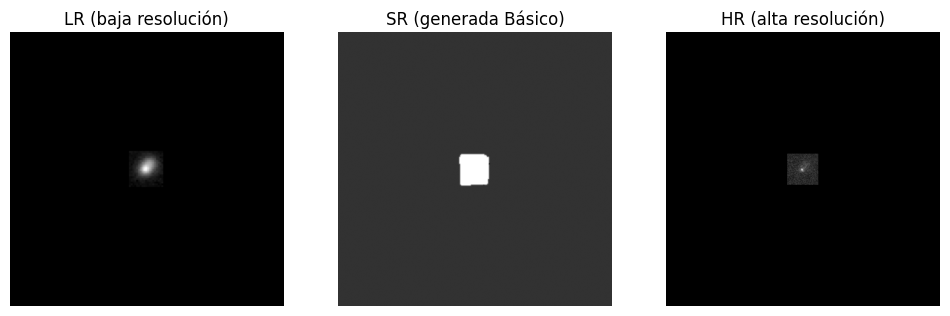

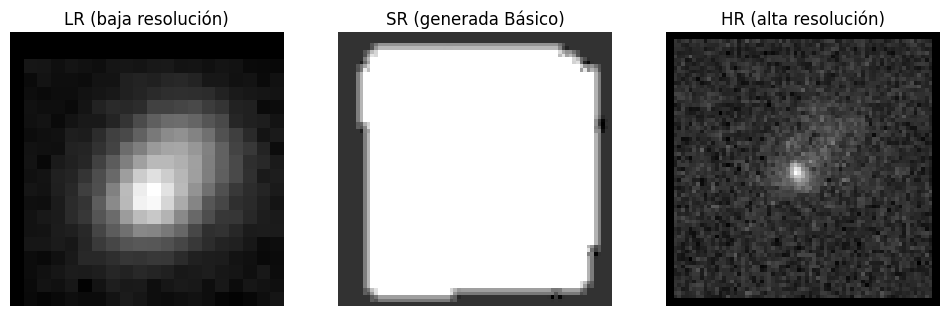

[Normalized] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


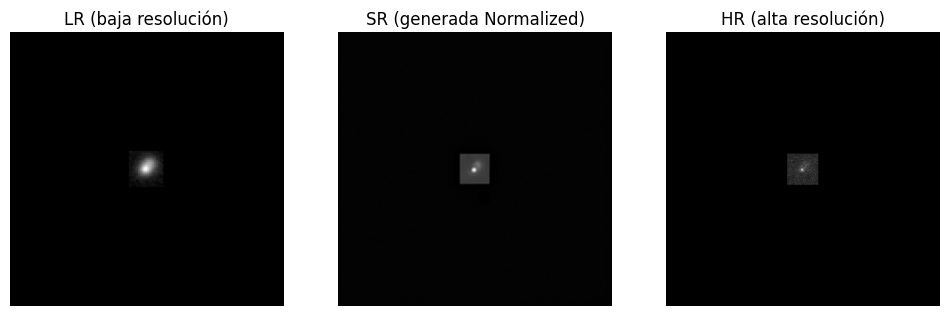

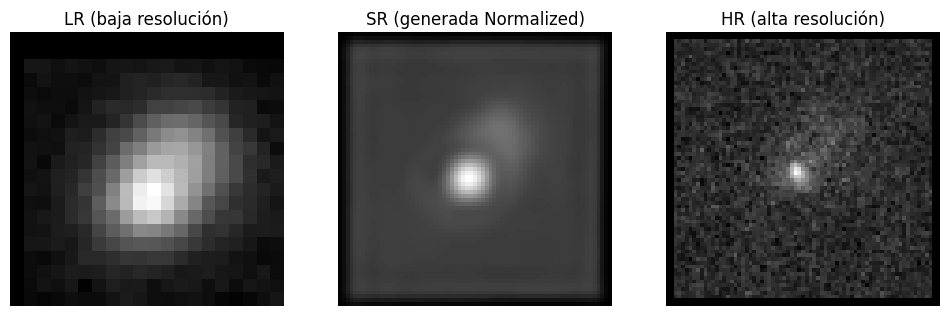

[Parametric] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


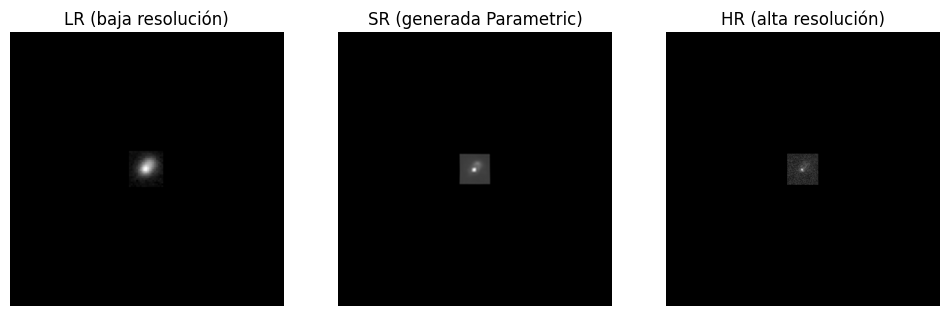

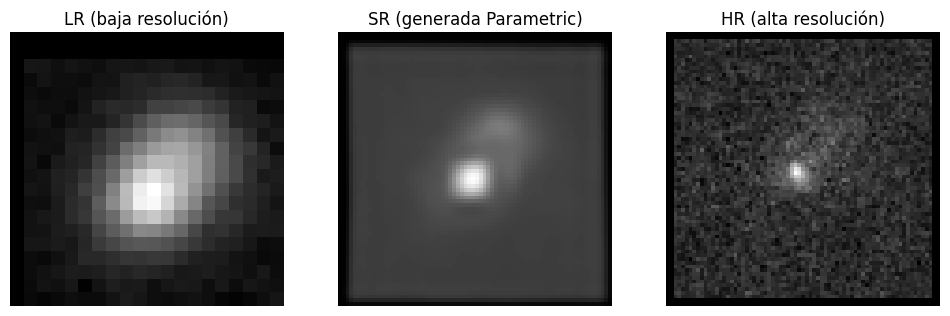

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filename = "n10_103_112779_aug1_rot90.png"

models_info = {
    "Básico": {
        "wrapper": DDPM_SuperRes_Wrapper,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/model_epoch_002.pth"
    },
    "Normalized": {
        "wrapper": DDPM_SuperRes_Wrapper_ELU,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion ELU/model_epoch_091.pth"
    },
    "Parametric": {
        "wrapper": DDPM_SuperRes_Wrapper_PReLU,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion PReLU/model_epoch_094.pth"
    }
}

for label, info in models_info.items():
    test_model(info["wrapper"], info["checkpoint"], filename, label)

[Básico] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


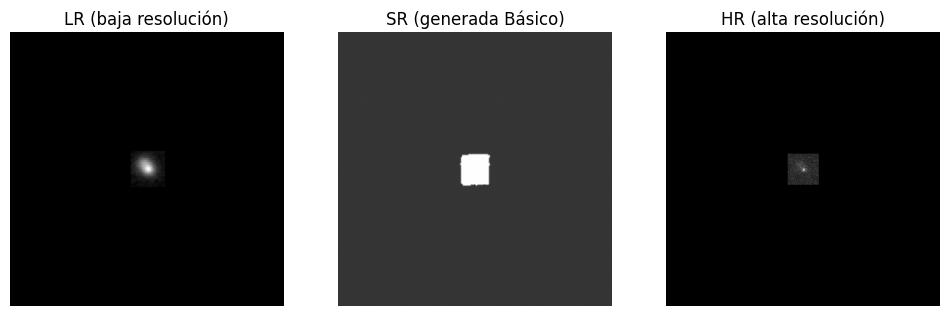

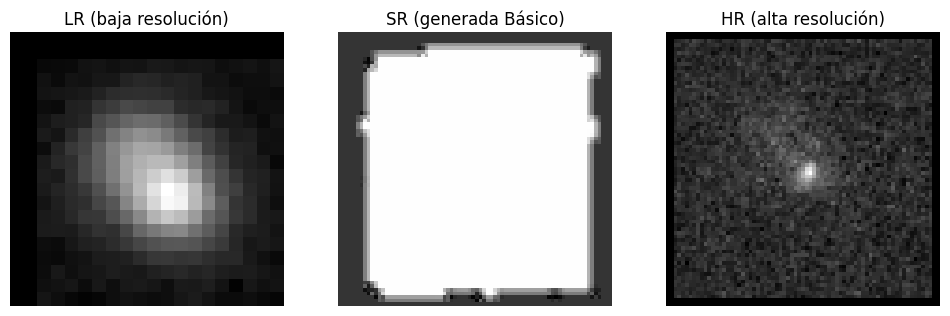

[Normalized] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


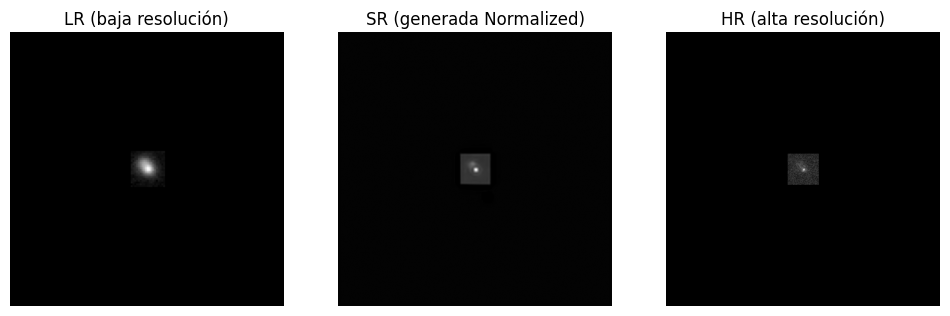

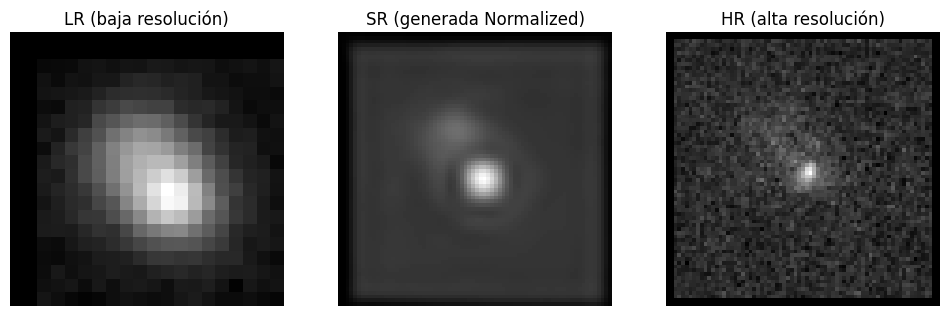

[Parametric] Imagen encontrada en test/
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


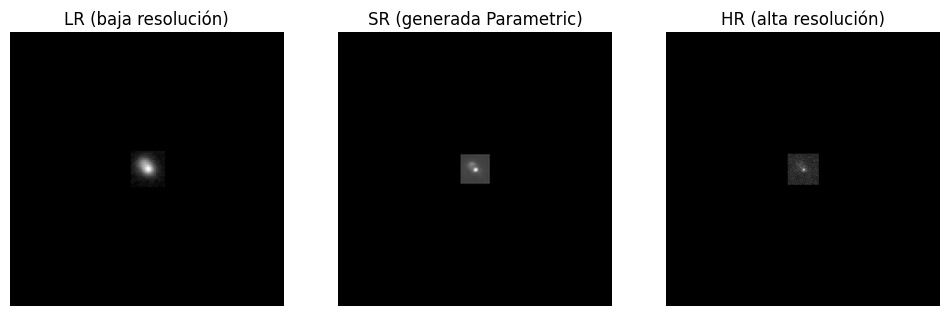

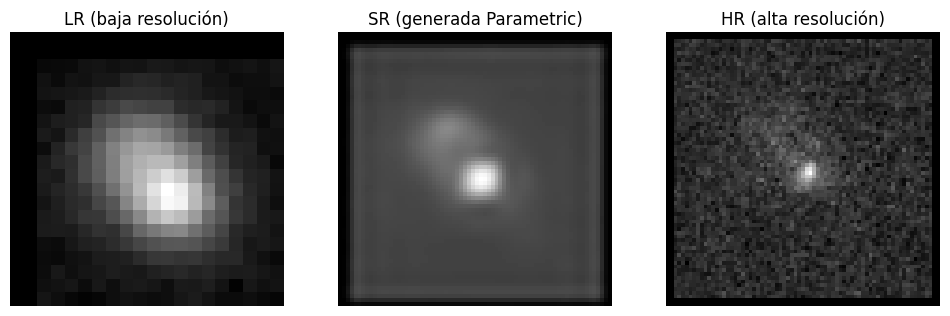

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filename = "n10_103_112779_aug7_fliplr_rot90.png"

models_info = {
    "Básico": {
        "wrapper": DDPM_SuperRes_Wrapper,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion/model_epoch_002.pth"
    },
    "Normalized": {
        "wrapper": DDPM_SuperRes_Wrapper_ELU,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion ELU/model_epoch_091.pth"
    },
    "Parametric": {
        "wrapper": DDPM_SuperRes_Wrapper_PReLU,
        "checkpoint": "/content/drive/MyDrive/Entrenamiento SegundoMiguelsuperResolucion PReLU/model_epoch_094.pth"
    }
}

for label, info in models_info.items():
    test_model(info["wrapper"], info["checkpoint"], filename, label)